In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns

from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, f_oneway

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Data Loading
data_path = './data/'
curated_mri_vif_df = pd.read_csv(data_path + '3_baseline_vif.csv')
curated_mri_vif_df = curated_mri_vif_df.dropna()
curated_mri_vif_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406 entries, 0 to 529
Data columns (total 64 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      406 non-null    float64
 1   fampd                                    406 non-null    int64  
 2   race_black                               406 non-null    bool   
 3   race_asian                               406 non-null    bool   
 4   race_other                               406 non-null    bool   
 5   sex                                      406 non-null    int64  
 6   educyrs                                  406 non-null    float64
 7   subgroup_gba                             406 non-null    bool   
 8   subgroup_lrrk2                           406 non-null    bool   
 9   subgroup_prkn                            406 non-null    bool   
 10  apoe_e4                                  406 non-null  

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lifelines.utils import concordance_index
from datetime import datetime
import os
import random
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
#
# RESEARCH QUESTION 4: MULTI-TASK LEARNING (MTL) ANALYSIS - FINAL FIXED VERSION
# CORRECTED COMBINED SCORE + DATA PROCESSING + LOSS BALANCING
#
# Author: GitHub Copilot (Final Fixed)
# Date: 9 September 2025
#
# =============================================================================

print("🔧 RQ4 CONFIGURATION: MTL WITH CORRECTED COMBINED SCORE")
print("=" * 70)

# Define modality groups
modality_groups = {
    'demographic_clinical': [
        'age', 'fampd', 'race_black', 'race_asian', 'race_other', 'sex',
        'educyrs', 'duration_yrs', 'ledd', 'mseadlg', 'hy', 'domside_left', 
        'domside_symmetric', 'hvltrdly', 'lns', 'vltanim', 'quip', 'ess', 'pigd', 
        'updrs2_score', 'updrs3_score', 'sdmtotal', 'stai', 'moca', 'rem', 'gds', 
        'bmi', 'updrs1_score', 'bjlot', 'scopa', 'upsit_pctl'
    ],
    'genetic': ['apoe_e4', 'subgroup_gba', 'subgroup_lrrk2', 'subgroup_prkn'],
    'biomarkers': ['urate', 'csfsaa_positive_lbd_like', 'csfsaa_positive_msa_like', 'csfsaa_inconclusive'],
    'datscan': ['mia_caudate_l', 'mia_caudate_r', 'mia_putamen_l', 'mia_putamen_r'],
    'mri': [f'mri_pc{i+1}' for i in range(10)]
}

# Configuration
REGRESSION_TARGET = 'moca_slope_iqr_cleaned'
SURVIVAL_TIME_TARGET = 'time_to_hy3_plus'
SURVIVAL_EVENT_TARGET = 'event_occurred'
ALL_MODALITIES = ['demographic_clinical', 'genetic', 'biomarkers', 'datscan', 'mri']

# 🔥 修复：正确的基线性能定义
BASELINE_PERFORMANCE = {
    'regression_r2': 0.21,
    'survival_c_index': 0.83,
    # 添加基线标准化参数
    'regression_r2_baseline': 0.0,  # 差于随机的基线
    'survival_c_index_baseline': 0.5  # 随机预测的基线
}

# Hyperparameter ranges
N_RANDOM_SEARCH = 6000  # 减少搜索次数用于测试
EPOCHS = 1000
RANDOM_STATE = 42
TEST_SIZE = 0.2

HYPERPARAMETER_RANGES = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.002],
    'batch_size': [32, 64, 128],
    'hidden_dim': [64, 128, 256],
    'alpha_regression': [0.01, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
    'alpha_survival': [0.01, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
    'l2_reg': [0.0, 0.0001, 0.001, 0.01],
    'dropout_rate': [0.2, 0.4],
    'n_layers': [2, 3],
    'activation': ['relu'],
    'batch_norm': [True, False],
    'early_stopping_patience': [80]
}

features_to_standardize = [
    'age', 'fampd', 'educyrs', 'apoe_e4', 'urate', 'mia_caudate_l', 'mia_caudate_r', 
    'mia_putamen_l', 'mia_putamen_r', 'duration_yrs', 'ledd', 'mseadlg', 'hy', 
    'hvltrdly', 'lns', 'vltanim', 'quip', 'ess', 'pigd', 'updrs2_score', 
    'updrs3_score', 'sdmtotal', 'stai', 'moca', 'rem', 'gds', 'bmi', 
    'updrs1_score', 'bjlot', 'scopa', 'upsit_pctl', 'mri_pc1', 'mri_pc2', 
    'mri_pc3', 'mri_pc4', 'mri_pc5', 'mri_pc6', 'mri_pc7', 'mri_pc8', 
    'mri_pc9', 'mri_pc10'
]

print(f"🎯 Targets: {REGRESSION_TARGET} + {SURVIVAL_TIME_TARGET}")
print(f"📊 Total features: {sum(len(modality_groups[mod]) for mod in ALL_MODALITIES)}")
print(f"⚙️ Experiments: {N_RANDOM_SEARCH}")

# Create directories
os.makedirs('results/mtl', exist_ok=True)
os.makedirs('results/models/mtl', exist_ok=True)

# Set seeds
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# --- CORRECTED COMBINED SCORE CALCULATION ---

def calculate_corrected_combined_score(test_r2, test_c_index, method='normalized_improvement'):
    """
    计算修正的组合分数
    
    Methods:
    1. 'simple_average': 简单平均 (原方法，有问题)
    2. 'normalized_improvement': 基于改善程度的归一化
    3. 'weighted_normalized': 加权归一化
    4. 'percentile_based': 基于百分位数的组合
    """
    
    if method == 'simple_average':
        # 原方法 - 有问题
        return test_r2 + test_c_index
    
    elif method == 'normalized_improvement':
        # 🔥 推荐方法：基于相对于基线的改善程度
        r2_baseline = BASELINE_PERFORMANCE['regression_r2_baseline']  # 0.0
        c_index_baseline = BASELINE_PERFORMANCE['survival_c_index_baseline']  # 0.5
        
        # 计算相对于基线的改善程度
        r2_improvement = (test_r2 - r2_baseline) / (1.0 - r2_baseline)  # 归一化到[0,1]
        c_index_improvement = (test_c_index - c_index_baseline) / (1.0 - c_index_baseline)  # 归一化到[0,1]
        
        # 处理负值情况
        r2_improvement = max(0, r2_improvement)
        c_index_improvement = max(0, c_index_improvement)
        
        # 等权重平均
        combined_score = 0.5 * r2_improvement + 0.5 * c_index_improvement
        
        return combined_score, r2_improvement, c_index_improvement
    
    elif method == 'weighted_normalized':
        # 加权版本 - 可以调整任务重要性
        r2_baseline = BASELINE_PERFORMANCE['regression_r2_baseline']
        c_index_baseline = BASELINE_PERFORMANCE['survival_c_index_baseline']
        
        r2_improvement = max(0, (test_r2 - r2_baseline) / (1.0 - r2_baseline))
        c_index_improvement = max(0, (test_c_index - c_index_baseline) / (1.0 - c_index_baseline))
        
        # 可调整权重 - 例如更重视生存分析
        w_r2 = 0.4  # 回归任务权重
        w_c_index = 0.6  # 生存任务权重
        
        combined_score = w_r2 * r2_improvement + w_c_index * c_index_improvement
        
        return combined_score, r2_improvement, c_index_improvement
    
    elif method == 'percentile_based':
        # 基于百分位数的方法 - 需要历史数据
        # 这里使用简化版本
        r2_percentile = min(100, max(0, (test_r2 - (-0.5)) / 1.5 * 100))  # 假设R²范围[-0.5, 1]
        c_index_percentile = (test_c_index - 0.5) / 0.5 * 100  # C-index范围[0.5, 1]
        
        combined_score = (r2_percentile + c_index_percentile) / 2 / 100
        
        return combined_score, r2_percentile/100, c_index_percentile/100

# --- PARAMETER GENERATOR ---

def generate_random_params():
    """Generate random hyperparameter combination"""
    return {
        'learning_rate': random.choice(HYPERPARAMETER_RANGES['learning_rate']),
        'batch_size': random.choice(HYPERPARAMETER_RANGES['batch_size']),
        'hidden_dim': random.choice(HYPERPARAMETER_RANGES['hidden_dim']),
        'alpha_regression': random.choice(HYPERPARAMETER_RANGES['alpha_regression']),
        'alpha_survival': random.choice(HYPERPARAMETER_RANGES['alpha_survival']),
        'l2_reg': random.choice(HYPERPARAMETER_RANGES['l2_reg']),
        'dropout_rate': random.choice(HYPERPARAMETER_RANGES['dropout_rate']),
        'n_layers': random.choice(HYPERPARAMETER_RANGES['n_layers']),
        'activation': random.choice(HYPERPARAMETER_RANGES['activation']),
        'batch_norm': random.choice(HYPERPARAMETER_RANGES['batch_norm']),
        'early_stopping_patience': random.choice(HYPERPARAMETER_RANGES['early_stopping_patience'])
    }

# --- FIXED DATA PREPROCESSING ---

class FixedMTLDataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_names = None
        self.fitted = False
        
    def prepare_and_split_data(self, df, test_size=0.2, random_state=42):
        """🔥 修复：正确的数据处理流程 - 先分割再处理"""
        try:
            # 1. 获取特征列表（不处理数据）
            feature_list = []
            for modality in ALL_MODALITIES:
                if modality in modality_groups:
                    feature_list.extend(modality_groups[modality])
            
            available_features = [f for f in feature_list if f in df.columns]
            
            # 2. 创建完整数据集（只选择列）
            required_cols = available_features + [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]
            complete_data = df[required_cols].copy()
            
            # 3. 转换目标列为数值型
            for col in [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]:
                complete_data[col] = pd.to_numeric(complete_data[col], errors='coerce')
            
            # 4. 删除NaN目标的行
            complete_data = complete_data.dropna(subset=[REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET])
            
            if len(complete_data) < 100:
                print(f"   ❌ Insufficient samples: {len(complete_data)}")
                return None
            
            # 5. 分割数据
            try:
                y_quartiles = pd.qcut(complete_data[REGRESSION_TARGET], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
                train_idx, test_idx = train_test_split(
                    range(len(complete_data)), 
                    test_size=test_size, 
                    random_state=random_state, 
                    stratify=y_quartiles
                )
            except:
                train_idx, test_idx = train_test_split(
                    range(len(complete_data)), 
                    test_size=test_size, 
                    random_state=random_state
                )
            
            # 6. 分别处理训练和测试数据
            train_data = complete_data.iloc[train_idx].copy()
            test_data = complete_data.iloc[test_idx].copy()
            
            # 7. 处理特征（分别处理以避免数据泄漏）
            X_train = self._process_features(train_data[available_features], fit_scaler=True)
            X_test = self._process_features(test_data[available_features], fit_scaler=False)
            
            return {
                'X_train': X_train,
                'X_test': X_test,
                'y_reg_train': train_data[REGRESSION_TARGET],
                'y_reg_test': test_data[REGRESSION_TARGET],
                'y_time_train': train_data[SURVIVAL_TIME_TARGET],
                'y_time_test': test_data[SURVIVAL_TIME_TARGET],
                'y_event_train': train_data[SURVIVAL_EVENT_TARGET],
                'y_event_test': test_data[SURVIVAL_EVENT_TARGET],
                'feature_names': available_features
            }
            
        except Exception as e:
            print(f"   ❌ Data preparation error: {str(e)}")
            return None
    
    def _process_features(self, X, fit_scaler=True):
        """处理特征：布尔转换 + 标准化"""
        X_processed = X.copy()
        
        # 布尔型转换
        for col in X_processed.columns:
            if X_processed[col].dtype == 'bool':
                X_processed[col] = X_processed[col].astype(int)
            elif X_processed[col].dtype == 'object':
                X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')
        
        X_processed = X_processed.fillna(0)
        
        # 标准化（只对指定特征）
        features_to_scale = [f for f in features_to_standardize if f in X_processed.columns]
        
        if features_to_scale:
            if fit_scaler:
                X_processed[features_to_scale] = self.scaler.fit_transform(X_processed[features_to_scale])
                self.fitted = True
            elif self.fitted:
                X_processed[features_to_scale] = self.scaler.transform(X_processed[features_to_scale])
        
        return X_processed.astype(np.float32)

# --- PYTORCH COMPONENTS ---

class MTLDataset(Dataset):
    def __init__(self, X, y_regression, y_time, y_event):
        # 确保数据是数值型
        X_processed = X.copy()
        for col in X_processed.columns:
            if X_processed[col].dtype == 'bool':
                X_processed[col] = X_processed[col].astype(int)
            elif X_processed[col].dtype == 'object':
                X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')
        
        X_processed = X_processed.fillna(0).astype(np.float32)
        
        self.X = torch.tensor(X_processed.values, dtype=torch.float32)
        self.y_regression = torch.tensor(y_regression.values.astype(np.float32), dtype=torch.float32).view(-1, 1)
        self.y_time = torch.tensor(y_time.values.astype(np.float32), dtype=torch.float32).view(-1, 1)
        self.y_event = torch.tensor(y_event.values.astype(np.float32), dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y_regression[idx], self.y_time[idx], self.y_event[idx]

class FixedMTLNet(nn.Module):
    def __init__(self, n_features, params):
        super(FixedMTLNet, self).__init__()
        
        hidden_dim = params['hidden_dim']
        n_layers = params['n_layers']
        dropout_rate = params['dropout_rate']
        batch_norm = params['batch_norm']
        
        self.activation_fn = nn.ReLU()
        
        # 共享编码器
        layers = []
        input_dim = n_features
        
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(self.activation_fn)
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim
        
        self.shared_encoder = nn.Sequential(*layers)
        
        # 任务特定头部
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            self.activation_fn,
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        self.survival_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            self.activation_fn,
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        shared_features = self.shared_encoder(x)
        regression_output = self.regression_head(shared_features)
        survival_output = self.survival_head(shared_features)
        return regression_output, survival_output

def enhanced_cox_loss(log_hazard, durations, events, eps=1e-8):
    """Enhanced Cox loss with numerical stability"""
    if torch.sum(events) == 0:
        return torch.tensor(0.0, requires_grad=True, device=log_hazard.device)
    
    sorted_indices = torch.argsort(durations.view(-1), descending=True)
    log_hazard_sorted = log_hazard.view(-1)[sorted_indices]
    events_sorted = events.view(-1)[sorted_indices]
    
    exp_hazard = torch.exp(torch.clamp(log_hazard_sorted, -20, 20))
    cumsum_exp = torch.cumsum(exp_hazard, dim=0)
    log_risk_set = torch.log(cumsum_exp + eps)
    
    event_mask = events_sorted == 1
    if torch.sum(event_mask) == 0:
        return torch.tensor(0.0, requires_grad=True, device=log_hazard.device)
    
    pll = torch.sum(log_hazard_sorted[event_mask] - log_risk_set[event_mask])
    return -pll

def compute_l2_regularization(model, l2_reg):
    """Compute L2 regularization term"""
    if l2_reg == 0:
        return torch.tensor(0.0, device=next(model.parameters()).device)
    
    l2_loss = torch.tensor(0.0, device=next(model.parameters()).device)
    for param in model.parameters():
        l2_loss += torch.norm(param, p=2) ** 2
    return l2_reg * l2_loss

def compute_balanced_mtl_loss(reg_pred, surv_pred, reg_target, time_target, event_target, 
                             alpha_regression, alpha_survival, model, l2_reg):
    """🔥 修复：平衡的MTL损失函数"""
    # 回归损失
    mse_loss = nn.MSELoss()(reg_pred, reg_target)
    
    # 生存损失
    cox_loss = enhanced_cox_loss(surv_pred, time_target, event_target)
    
    # L2正则化
    l2_loss = compute_l2_regularization(model, l2_reg)
    
    # 🔥 关键修复：损失规模归一化
    # 动态平衡损失规模
    if not torch.isnan(mse_loss) and not torch.isnan(cox_loss) and mse_loss > 0 and cox_loss > 0:
        # 计算损失的相对规模
        mse_scale = mse_loss.detach()
        cox_scale = cox_loss.detach()
        
        # 归一化权重，使两个损失在相似的数量级
        if mse_scale > 0 and cox_scale > 0:
            scale_factor = mse_scale / cox_scale
            # 如果Cox损失太小，增加其权重
            adjusted_alpha_survival = alpha_survival * max(1.0, scale_factor / 10.0)
            total_loss = alpha_regression * mse_loss + adjusted_alpha_survival * cox_loss + l2_loss
        else:
            total_loss = alpha_regression * mse_loss + alpha_survival * cox_loss + l2_loss
    else:
        total_loss = alpha_regression * mse_loss + alpha_survival * cox_loss + l2_loss
    
    return total_loss, mse_loss, cox_loss, l2_loss

class EarlyStopping:
    def __init__(self, patience=50, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

print("✅ Fixed components defined!")

# --- FIXED MTL PIPELINE ---

class FixedMTLPipeline:
    def __init__(self, params):
        self.params = params
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.preprocessor = FixedMTLDataPreprocessor()
        
    def train_and_evaluate(self, df):
        """训练和评估修复的MTL模型"""
        # 使用修复的数据处理
        data = self.preprocessor.prepare_and_split_data(df)
        if data is None:
            return None
        
        try:
            # 创建数据集
            train_dataset = MTLDataset(
                data['X_train'], data['y_reg_train'], 
                data['y_time_train'], data['y_event_train']
            )
            
            train_loader = DataLoader(
                train_dataset, 
                batch_size=min(self.params['batch_size'], len(train_dataset)), 
                shuffle=True,
                drop_last=False
            )
            
            # 初始化模型
            model = FixedMTLNet(
                n_features=train_dataset.X.shape[1], 
                params=self.params
            ).to(self.device)
            
            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr=self.params['learning_rate']
            )
            
            early_stopping = EarlyStopping(patience=self.params['early_stopping_patience'])
            
            # 训练循环
            model.train()
            train_losses = []
            
            for epoch in range(EPOCHS):
                epoch_losses = []
                epoch_mse_losses = []
                epoch_cox_losses = []
                
                for X_batch, y_reg_batch, y_time_batch, y_event_batch in train_loader:
                    X_batch = X_batch.to(self.device)
                    y_reg_batch = y_reg_batch.to(self.device)
                    y_time_batch = y_time_batch.to(self.device)
                    y_event_batch = y_event_batch.to(self.device)
                    
                    optimizer.zero_grad()
                    
                    reg_pred, surv_pred = model(X_batch)
                    
                    # 使用平衡的MTL损失
                    total_loss, mse_loss, cox_loss, l2_loss = compute_balanced_mtl_loss(
                        reg_pred, surv_pred, y_reg_batch, y_time_batch, y_event_batch,
                        self.params['alpha_regression'], self.params['alpha_survival'], 
                        model, self.params['l2_reg']
                    )
                    
                    total_loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    
                    epoch_losses.append(total_loss.item())
                    epoch_mse_losses.append(mse_loss.item())
                    epoch_cox_losses.append(cox_loss.item())
                
                if epoch_losses:
                    avg_epoch_loss = np.mean(epoch_losses)
                    train_losses.append(avg_epoch_loss)
                    
                    if early_stopping(avg_epoch_loss):
                        break
            
            # 评估
            model.eval()
            with torch.no_grad():
                X_test_processed = data['X_test'].copy()
                
                for col in X_test_processed.columns:
                    if X_test_processed[col].dtype == 'bool':
                        X_test_processed[col] = X_test_processed[col].astype(int)
                    elif X_test_processed[col].dtype == 'object':
                        X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')
                
                X_test_processed = X_test_processed.fillna(0).astype(np.float32)
                X_test_tensor = torch.tensor(X_test_processed.values, dtype=torch.float32).to(self.device)
                
                reg_pred_test, surv_pred_test = model(X_test_tensor)
                
                # 回归指标
                reg_pred_test_np = reg_pred_test.cpu().numpy().flatten()
                test_r2 = r2_score(data['y_reg_test'], reg_pred_test_np)
                test_mae = mean_absolute_error(data['y_reg_test'], reg_pred_test_np)
                test_rmse = np.sqrt(mean_squared_error(data['y_reg_test'], reg_pred_test_np))
                
                # 生存指标
                surv_pred_test_np = surv_pred_test.cpu().numpy().flatten()
                test_c_index = concordance_index(
                    data['y_time_test'], 
                    -surv_pred_test_np,
                    data['y_event_test']
                )
            
            # 🔥 关键修复：使用正确的Combined Score计算
            combined_score, r2_normalized, c_index_normalized = calculate_corrected_combined_score(
                test_r2, test_c_index, method='normalized_improvement'
            )
            
            # 计算相对于基线的改善
            r2_improvement = test_r2 - BASELINE_PERFORMANCE['regression_r2']
            c_index_improvement = test_c_index - BASELINE_PERFORMANCE['survival_c_index']
            
            return {
                'n_features': len(data['feature_names']),
                'n_train': len(data['X_train']),
                'n_test': len(data['X_test']),
                'test_r2': test_r2,
                'test_mae': test_mae,
                'test_rmse': test_rmse,
                'test_c_index': test_c_index,
                'r2_improvement': r2_improvement,
                'c_index_improvement': c_index_improvement,
                # 🔥 新增：正确的组合分数
                'combined_score': combined_score,
                'combined_score_simple': test_r2 + test_c_index,  # 原方法作对比
                'r2_normalized': r2_normalized,
                'c_index_normalized': c_index_normalized,
                'epochs_trained': len(train_losses),
                'final_train_loss': train_losses[-1] if train_losses else np.nan,
                'avg_mse_loss': np.mean(epoch_mse_losses) if epoch_mse_losses else np.nan,
                'avg_cox_loss': np.mean(epoch_cox_losses) if epoch_cox_losses else np.nan,
                'model': model,
                'scaler': self.preprocessor.scaler,
                'feature_names': data['feature_names'],
                **self.params
            }
            
        except Exception as e:
            print(f"      Training error: {str(e)}")
            return None

# --- MAIN EXECUTION ---

def run_fixed_mtl_experiment(df):
    """运行修复的MTL实验"""
    
    print("🚀 STARTING FIXED MTL EXPERIMENT")
    print("=" * 80)
    
    all_results = []
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print(f"📊 Experiments: {N_RANDOM_SEARCH}")
    print(f"📅 Epochs per experiment: {EPOCHS}")
    
    print(f"\n🎯 BASELINE COMPARISON:")
    print(f"   • Regression R²: {BASELINE_PERFORMANCE['regression_r2']:.3f}")
    print(f"   • Survival C-index: {BASELINE_PERFORMANCE['survival_c_index']:.3f}")
    
    print(f"\n🔧 FIXED MTL FEATURES:")
    print(f"   • Corrected data processing (no leakage)")
    print(f"   • Balanced loss function")
    print(f"   • Normalized combined score")
    
    # 跟踪最佳结果
    best_combined_score = -np.inf
    best_result = None
    successful_experiments = 0
    
    for experiment_id in range(1, N_RANDOM_SEARCH + 1):
        print(f"\n--- Experiment {experiment_id}/{N_RANDOM_SEARCH} ---")
        
        params = generate_random_params()
        print(f"Params: lr={params['learning_rate']}, bs={params['batch_size']}, "
              f"hd={params['hidden_dim']}, αr={params['alpha_regression']}, αs={params['alpha_survival']}")
        
        try:
            pipeline = FixedMTLPipeline(params)
            result = pipeline.train_and_evaluate(df)
            
            if result is not None:
                successful_experiments += 1
                
                result.update({
                    'timestamp': timestamp,
                    'experiment_id': experiment_id
                })
                
                # 显示关键指标
                print(f"📊 R²: {result['test_r2']:.4f} | C-idx: {result['test_c_index']:.4f}")
                print(f"📊 R² Δ: {result['r2_improvement']:+.4f} | C-idx Δ: {result['c_index_improvement']:+.4f}")
                print(f"📊 Combined (norm): {result['combined_score']:.4f} | Combined (simple): {result['combined_score_simple']:.4f}")
                print(f"📊 Epochs: {result['epochs_trained']}")
                
                all_results.append(result)
                
                # 🔥 使用正确的combined score选择最佳模型
                if result['combined_score'] > best_combined_score:
                    best_combined_score = result['combined_score']
                    best_result = result.copy()
                    
                    # 保存最佳模型
                    model_path = f"results/models/mtl/best_fixed_mtl_{timestamp}.pt"
                    torch.save({
                        'model_state_dict': result['model'].state_dict(),
                        'params': params,
                        'metrics': {
                            'test_r2': result['test_r2'],
                            'test_c_index': result['test_c_index'],
                            'combined_score': result['combined_score'],
                            'combined_score_simple': result['combined_score_simple'],
                            'r2_improvement': result['r2_improvement'],
                            'c_index_improvement': result['c_index_improvement']
                        },
                        'feature_names': result['feature_names']
                    }, model_path)
                    print(f"💾 New best model saved!")
            
            else:
                print("⚠️ Training failed")
            
        except Exception as e:
            print(f"❌ Error: {str(e)}")
            continue
    
    print(f"\n✅ Completed: {successful_experiments}/{N_RANDOM_SEARCH} successful")
    return all_results, best_result, timestamp

# 执行实验
if __name__ == '__main__':
    # 加载数据
    data_path = './data/'
    curated_mri_vif_df = pd.read_csv(data_path + '3_baseline_vif.csv')
    curated_mri_vif_df = curated_mri_vif_df.dropna()
    
    print("🎯 Starting Fixed MTL Experiment")
    print(f"Data shape: {curated_mri_vif_df.shape}")
    
    # 运行实验
    all_results, best_result, timestamp = run_fixed_mtl_experiment(curated_mri_vif_df)
    
    # --- 结果分析 ---
    if all_results:
        results_df = pd.DataFrame(all_results)
        
        print("\n" + "="*80)
        print("🏆 FIXED MTL EXPERIMENT RESULTS")
        print("="*80)
        
        # 最佳模型
        if best_result:
            print(f"\n🥇 BEST FIXED MTL MODEL:")
            print(f"   • Test R²: {best_result['test_r2']:.4f} (Δ = {best_result['r2_improvement']:+.4f})")
            print(f"   • Test C-index: {best_result['test_c_index']:.4f} (Δ = {best_result['c_index_improvement']:+.4f})")
            print(f"   • Combined Score (normalized): {best_result['combined_score']:.4f}")
            print(f"   • Combined Score (simple): {best_result['combined_score_simple']:.4f}")
            print(f"   • R² normalized: {best_result['r2_normalized']:.4f}")
            print(f"   • C-index normalized: {best_result['c_index_normalized']:.4f}")
            print(f"   • Hyperparameters:")
            print(f"     - α_regression: {best_result['alpha_regression']}")
            print(f"     - α_survival: {best_result['alpha_survival']}")
            print(f"     - Learning rate: {best_result['learning_rate']}")
            print(f"     - Hidden dim: {best_result['hidden_dim']}")
            print(f"     - L2 reg: {best_result['l2_reg']}")
        
        # 统计总结
        print(f"\n📊 EXPERIMENT SUMMARY:")
        print(f"   • Mean R²: {results_df['test_r2'].mean():.4f} ± {results_df['test_r2'].std():.4f}")
        print(f"   • Mean C-index: {results_df['test_c_index'].mean():.4f} ± {results_df['test_c_index'].std():.4f}")
        print(f"   • Mean Combined (norm): {results_df['combined_score'].mean():.4f} ± {results_df['combined_score'].std():.4f}")
        print(f"   • Mean Combined (simple): {results_df['combined_score_simple'].mean():.4f} ± {results_df['combined_score_simple'].std():.4f}")
        
        # 改善分析
        r2_improvements = results_df['r2_improvement'] > 0
        c_index_improvements = results_df['c_index_improvement'] > 0
        both_improvements = r2_improvements & c_index_improvements
        
        print(f"\n📈 IMPROVEMENT ANALYSIS:")
        print(f"   • R² improvements: {r2_improvements.sum()}/{len(results_df)} ({100*r2_improvements.mean():.1f}%)")
        print(f"   • C-index improvements: {c_index_improvements.sum()}/{len(results_df)} ({100*c_index_improvements.mean():.1f}%)")
        print(f"   • Both improvements: {both_improvements.sum()}/{len(results_df)} ({100*both_improvements.mean():.1f}%)")
        
        # 前10名模型
        top_10 = results_df.nlargest(10, 'combined_score')[
            ['test_r2', 'test_c_index', 'combined_score', 'combined_score_simple', 
             'r2_improvement', 'c_index_improvement', 'alpha_regression', 'alpha_survival', 
             'learning_rate', 'hidden_dim', 'l2_reg']
        ]
        
        print(f"\n🏆 TOP 10 MODELS (by normalized combined score):")
        print(top_10.round(4).to_string())
        
        # 保存结果
        results_file = f'results/mtl/fixed_mtl_results_{timestamp}.csv'
        results_df.to_csv(results_file, index=False)
        
        # 最终结论
        print(f"\n🎯 FINAL CONCLUSION:")
        if best_result:
            if best_result['r2_improvement'] > 0 and best_result['c_index_improvement'] > 0:
                print("✅ FIXED MTL OUTPERFORMS on BOTH tasks!")
            elif best_result['r2_improvement'] > 0:
                print("⚠️ FIXED MTL OUTPERFORMS on regression only")
            elif best_result['c_index_improvement'] > 0:
                print("⚠️ FIXED MTL OUTPERFORMS on survival only")
            else:
                print("❌ FIXED MTL does NOT outperform baselines")
        
        print(f"\n💾 Results saved: {results_file}")
        
        # Combined Score方法比较
        print(f"\n📊 COMBINED SCORE METHOD COMPARISON:")
        correlation = results_df[['combined_score', 'combined_score_simple']].corr().iloc[0, 1]
        print(f"   • Correlation between methods: {correlation:.4f}")
        
        # 看看哪些模型在两种方法下排名差异最大
        results_df['rank_normalized'] = results_df['combined_score'].rank(ascending=False)
        results_df['rank_simple'] = results_df['combined_score_simple'].rank(ascending=False)
        results_df['rank_diff'] = abs(results_df['rank_normalized'] - results_df['rank_simple'])
        
        print(f"   • Mean rank difference: {results_df['rank_diff'].mean():.1f}")
        print(f"   • Max rank difference: {results_df['rank_diff'].max():.0f}")
        
    print("\n" + "🎉" * 30)
    print("FIXED MTL EXPERIMENT COMPLETE")
    print("🎉" * 30)

🔧 RQ4 CONFIGURATION: MTL WITH CORRECTED COMBINED SCORE
🎯 Targets: moca_slope_iqr_cleaned + time_to_hy3_plus
📊 Total features: 53
⚙️ Experiments: 100
✅ Fixed components defined!
🎯 Starting Fixed MTL Experiment
Data shape: (406, 64)
🚀 STARTING FIXED MTL EXPERIMENT
📊 Experiments: 100
📅 Epochs per experiment: 200

🎯 BASELINE COMPARISON:
   • Regression R²: 0.210
   • Survival C-index: 0.830

🔧 FIXED MTL FEATURES:
   • Corrected data processing (no leakage)
   • Balanced loss function
   • Normalized combined score

--- Experiment 1/100 ---
Params: lr=0.0001, bs=32, hd=256, αr=0.7, αs=0.5
📊 R²: 0.0781 | C-idx: 0.7483
📊 R² Δ: -0.1319 | C-idx Δ: -0.0817
📊 Combined (norm): 0.2873 | Combined (simple): 0.8264
📊 Epochs: 200
💾 New best model saved!

--- Experiment 2/100 ---
Params: lr=0.0001, bs=32, hd=64, αr=0.5, αs=1.5
📊 R²: 0.0387 | C-idx: 0.8160
📊 R² Δ: -0.1713 | C-idx Δ: -0.0140
📊 Combined (norm): 0.3354 | Combined (simple): 0.8547
📊 Epochs: 200
💾 New best model saved!

--- Experiment 3/100 -

In [ ]:
# # =============================================================================
# #
# # RESEARCH QUESTION 4: MULTI-TASK LEARNING (MTL) ANALYSIS - FINAL VERSION
# # FOCUSED ON ALL_MODALITIES COMPARISON - RANDOM SEARCH + DATA FIX
# #
# # Author: GitHub Copilot (Final)
# # Date: 9 September 2025
# #
# # Purpose:
# # - Multi-Task Learning with shared encoder + two task-specific heads
# # - Regression head: Predicts MoCA slope (most stable from RQ1)  
# # - Survival head: Predicts time-to-HY≥3 risk using Cox partial likelihood
# # - FIXED: Data type issues + Random search (100 experiments)
# # - Compare against best single-task models from RQ1 and RQ2
# #
# # =============================================================================

# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from lifelines.utils import concordance_index
# from datetime import datetime
# import os
# import random
# import warnings
# warnings.filterwarnings('ignore')

# # --- 1. FINAL CONFIGURATION FOR RQ4 ---

# print("🔧 RQ4 CONFIGURATION: ALL_MODALITIES FOCUS - FINAL VERSION")
# print("=" * 70)

# # Define modality groups
# modality_groups = {
#     'demographic_clinical': [
#         'age', 'fampd', 'race_black', 'race_asian', 'race_other', 'sex',
#         'educyrs', 'duration_yrs', 'ledd', 'mseadlg', 'hy', 'domside_left', 
#         'domside_symmetric', 'hvltrdly', 'lns', 'vltanim', 'quip', 'ess', 'pigd', 
#         'updrs2_score', 'updrs3_score', 'sdmtotal', 'stai', 'moca', 'rem', 'gds', 
#         'bmi', 'updrs1_score', 'bjlot', 'scopa', 'upsit_pctl'
#     ],
#     'genetic': ['apoe_e4', 'subgroup_gba', 'subgroup_lrrk2', 'subgroup_prkn'],
#     'biomarkers': ['urate', 'csfsaa_positive_lbd_like', 'csfsaa_positive_msa_like', 'csfsaa_inconclusive'],
#     'datscan': ['mia_caudate_l', 'mia_caudate_r', 'mia_putamen_l', 'mia_putamen_r'],
#     'mri': [f'mri_pc{i+1}' for i in range(10)]
# }

# # RQ4 Specific Targets
# REGRESSION_TARGET = 'moca_slope_iqr_cleaned'  # Most stable from RQ1
# SURVIVAL_TIME_TARGET = 'time_to_hy3_plus'
# SURVIVAL_EVENT_TARGET = 'event_occurred'

# # ONLY ALL_MODALITIES for comparison
# ALL_MODALITIES = ['demographic_clinical', 'genetic', 'biomarkers', 'datscan', 'mri']

# # BASELINE PERFORMANCE FROM RQ1 & RQ2 (Single-Task Models)
# BASELINE_PERFORMANCE = {
#     'regression_r2': 0.21,  # Best single-task regression R² for MoCA (all_modalities)
#     'survival_c_index': 0.83  # Best single-task survival C-index (all_modalities)
# }

# # FINAL: Random search with reasonable parameter ranges
# N_RANDOM_SEARCH = 6000  # Much more reasonable
# EPOCHS = 500
# RANDOM_STATE = 42
# TEST_SIZE = 0.2

# # FINAL: Simplified hyperparameter ranges for random search
# HYPERPARAMETER_RANGES = {
#     'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
#     'batch_size': [32, 64, 128],
#     'hidden_dim': [64, 128, 256],
#     'alpha_regression': [0.05, 0.1, 0.3, 0.5, 0.7, 1.0],      # Weight for regression loss
#     'alpha_survival': [0.05, 0.1, 0.3, 0.5, 0.7, 1.0],       # Weight for survival loss
#     'l2_reg': [0.0, 0.001, 0.01, 0.05],            # L2 regularization
#     'dropout_rate': [0.3, 0.5],
#     'n_layers': [2, 3],
#     'activation': ['relu'],                   # Simplified to just relu
#     'batch_norm': [True, False],
#     'early_stopping_patience': [50]           # Fixed patience
# }

# # Features to standardize
# features_to_standardize = [
#     'age', 'fampd', 'educyrs', 'apoe_e4', 'urate', 'mia_caudate_l', 'mia_caudate_r', 
#     'mia_putamen_l', 'mia_putamen_r', 'duration_yrs', 'ledd', 'mseadlg', 'hy', 
#     'hvltrdly', 'lns', 'vltanim', 'quip', 'ess', 'pigd', 'updrs2_score', 
#     'updrs3_score', 'sdmtotal', 'stai', 'moca', 'rem', 'gds', 'bmi', 
#     'updrs1_score', 'bjlot', 'scopa', 'upsit_pctl', 'mri_pc1', 'mri_pc2', 
#     'mri_pc3', 'mri_pc4', 'mri_pc5', 'mri_pc6', 'mri_pc7', 'mri_pc8', 
#     'mri_pc9', 'mri_pc10'
# ]

# print(f"🎯 RQ4 Targets:")
# print(f"   • Regression: {REGRESSION_TARGET}")
# print(f"   • Survival: {SURVIVAL_TIME_TARGET} (event: {SURVIVAL_EVENT_TARGET})")

# print(f"\n📊 All Modalities Features:")
# total_features = sum(len(modality_groups[mod]) for mod in ALL_MODALITIES)
# print(f"   • Total features: {total_features}")

# print(f"\n📈 Baseline Performance (Single-Task Models):")
# print(f"   • Regression R²: {BASELINE_PERFORMANCE['regression_r2']:.3f}")
# print(f"   • Survival C-index: {BASELINE_PERFORMANCE['survival_c_index']:.3f}")

# print(f"\n⚙️ Random search experiments: {N_RANDOM_SEARCH}")
# print(f"📅 Epochs per experiment: {EPOCHS}")
# print(f"🔧 FINAL: Fixed data type issues + Reasonable search space")

# # Create results directory
# os.makedirs('results/mtl', exist_ok=True)
# os.makedirs('results/models/mtl', exist_ok=True)

# # Set seeds for reproducibility
# torch.manual_seed(RANDOM_STATE)
# np.random.seed(RANDOM_STATE)
# random.seed(RANDOM_STATE)

# # --- 2. RANDOM SEARCH PARAMETER GENERATOR ---

# def generate_random_params():
#     """Generate random hyperparameter combination"""
#     return {
#         'learning_rate': random.choice(HYPERPARAMETER_RANGES['learning_rate']),
#         'batch_size': random.choice(HYPERPARAMETER_RANGES['batch_size']),
#         'hidden_dim': random.choice(HYPERPARAMETER_RANGES['hidden_dim']),
#         'alpha_regression': random.choice(HYPERPARAMETER_RANGES['alpha_regression']),
#         'alpha_survival': random.choice(HYPERPARAMETER_RANGES['alpha_survival']),
#         'l2_reg': random.choice(HYPERPARAMETER_RANGES['l2_reg']),
#         'dropout_rate': random.choice(HYPERPARAMETER_RANGES['dropout_rate']),
#         'n_layers': random.choice(HYPERPARAMETER_RANGES['n_layers']),
#         'activation': random.choice(HYPERPARAMETER_RANGES['activation']),
#         'batch_norm': random.choice(HYPERPARAMETER_RANGES['batch_norm']),
#         'early_stopping_patience': random.choice(HYPERPARAMETER_RANGES['early_stopping_patience'])
#     }

# # --- 3. FIXED DATA PREPROCESSING ---

# class MTLDataPreprocessor:
#     def __init__(self):
#         self.scaler = StandardScaler()
#         self.feature_names = None
        
#     def prepare_features(self, df, modality_list):
#         """Prepare feature matrix for all modalities with BOOLEAN FIX"""
#         feature_list = []
#         for modality in modality_list:
#             if modality in modality_groups:
#                 feature_list.extend(modality_groups[modality])
        
#         # Filter features that exist in the dataframe
#         available_features = [f for f in feature_list if f in df.columns]
#         X = df[available_features].copy()
        
#         # 🔥 关键修复：处理布尔型特征
#         for col in X.columns:
#             if X[col].dtype == 'bool':
#                 # 将布尔型转换为0/1
#                 X[col] = X[col].astype(int)
#             elif X[col].dtype == 'object':
#                 # 处理其他对象类型
#                 X[col] = pd.to_numeric(X[col], errors='coerce')
        
#         # Fill any remaining NaN values with 0
#         X = X.fillna(0)
        
#         self.feature_names = available_features
#         return X, available_features
    
#     def create_stratified_split(self, df, test_size=0.2, random_state=42):
#         """Create stratified train-test split using regression target quartiles"""
#         try:
#             # Use regression target for stratification
#             y_quartiles = pd.qcut(df[REGRESSION_TARGET], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
            
#             train_idx, test_idx = train_test_split(
#                 range(len(df)), 
#                 test_size=test_size, 
#                 random_state=random_state, 
#                 stratify=y_quartiles
#             )
#         except:
#             # Fallback to simple random split if stratification fails
#             train_idx, test_idx = train_test_split(
#                 range(len(df)), 
#                 test_size=test_size, 
#                 random_state=random_state
#             )
        
#         return train_idx, test_idx
    
#     def standardize_features(self, X_train, X_test):
#         """Standardize specified features"""
#         X_train_scaled = X_train.copy()
#         X_test_scaled = X_test.copy()
        
#         # Identify which features need standardization and are available
#         features_to_scale = [f for f in features_to_standardize if f in X_train.columns]
        
#         if features_to_scale:
#             # Fit scaler on training data and transform both sets
#             X_train_scaled[features_to_scale] = self.scaler.fit_transform(X_train[features_to_scale])
#             X_test_scaled[features_to_scale] = self.scaler.transform(X_test[features_to_scale])
        
#         return X_train_scaled, X_test_scaled

# print("✅ FIXED data preprocessing defined!")

# # --- 4. FIXED PYTORCH COMPONENTS ---

# class MTLDataset(Dataset):
#     def __init__(self, X, y_regression, y_time, y_event):
#         # 🔥 修复：不再过滤布尔型，而是确保所有列都是数值型
#         X_processed = X.copy()
        
#         # 将布尔型转为int，对象型尝试转数值型
#         for col in X_processed.columns:
#             if X_processed[col].dtype == 'bool':
#                 X_processed[col] = X_processed[col].astype(int)
#             elif X_processed[col].dtype == 'object':
#                 X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')
        
#         # 填充NaN并确保是float32
#         X_processed = X_processed.fillna(0).astype(np.float32)
        
#         self.X = torch.tensor(X_processed.values, dtype=torch.float32)
#         self.y_regression = torch.tensor(y_regression.values.astype(np.float32), dtype=torch.float32).view(-1, 1)
#         self.y_time = torch.tensor(y_time.values.astype(np.float32), dtype=torch.float32).view(-1, 1)
#         self.y_event = torch.tensor(y_event.values.astype(np.float32), dtype=torch.float32).view(-1, 1)
    
#     # 🔥 添加缺失的方法
#     def __len__(self):
#         return len(self.X)
    
#     def __getitem__(self, idx):
#         return self.X[idx], self.y_regression[idx], self.y_time[idx], self.y_event[idx]

# class FinalMTLRegressionSurvivalNet(nn.Module):
#     def __init__(self, n_features, params):
#         super(FinalMTLRegressionSurvivalNet, self).__init__()
        
#         hidden_dim = params['hidden_dim']
#         n_layers = params['n_layers']
#         dropout_rate = params['dropout_rate']
#         batch_norm = params['batch_norm']
        
#         # Use ReLU activation (simplified)
#         self.activation_fn = nn.ReLU()
        
#         # Build shared encoder layers
#         layers = []
#         input_dim = n_features
        
#         for i in range(n_layers):
#             layers.append(nn.Linear(input_dim, hidden_dim))
#             if batch_norm:
#                 layers.append(nn.BatchNorm1d(hidden_dim))
#             layers.append(self.activation_fn)
#             layers.append(nn.Dropout(dropout_rate))
#             input_dim = hidden_dim
        
#         self.shared_encoder = nn.Sequential(*layers)
        
#         # Task-specific heads
#         self.regression_head = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             self.activation_fn,
#             nn.Dropout(dropout_rate / 2),
#             nn.Linear(hidden_dim // 2, 1)
#         )
        
#         self.survival_head = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             self.activation_fn,
#             nn.Dropout(dropout_rate / 2),
#             nn.Linear(hidden_dim // 2, 1)
#         )

#     def forward(self, x):
#         shared_features = self.shared_encoder(x)
#         regression_output = self.regression_head(shared_features)
#         survival_output = self.survival_head(shared_features)
#         return regression_output, survival_output

# def enhanced_cox_loss(log_hazard, durations, events, eps=1e-8):
#     """Enhanced Cox loss with numerical stability"""
#     if torch.sum(events) == 0:
#         return torch.tensor(0.0, requires_grad=True, device=log_hazard.device)
    
#     # Sort by duration (descending)
#     sorted_indices = torch.argsort(durations.view(-1), descending=True)
#     log_hazard_sorted = log_hazard.view(-1)[sorted_indices]
#     events_sorted = events.view(-1)[sorted_indices]
    
#     # Compute log risk set with numerical stability
#     exp_hazard = torch.exp(torch.clamp(log_hazard_sorted, -20, 20))  # Clamp for stability
#     cumsum_exp = torch.cumsum(exp_hazard, dim=0)
#     log_risk_set = torch.log(cumsum_exp + eps)
    
#     # Compute partial log-likelihood only for events
#     event_mask = events_sorted == 1
#     if torch.sum(event_mask) == 0:
#         return torch.tensor(0.0, requires_grad=True, device=log_hazard.device)
    
#     pll = torch.sum(log_hazard_sorted[event_mask] - log_risk_set[event_mask])
#     return -pll

# def compute_l2_regularization(model, l2_reg):
#     """Compute L2 regularization term"""
#     if l2_reg == 0:
#         return torch.tensor(0.0, device=next(model.parameters()).device)
    
#     l2_loss = torch.tensor(0.0, device=next(model.parameters()).device)
#     for param in model.parameters():
#         l2_loss += torch.norm(param, p=2) ** 2
#     return l2_reg * l2_loss

# def compute_mtl_loss(reg_pred, surv_pred, reg_target, time_target, event_target, 
#                      alpha_regression, alpha_survival, model, l2_reg):
#     """
#     Compute combined MTL loss: α₁·MSE + α₂·Cox + λ·L2
#     """
#     # Regression loss (MSE)
#     mse_loss = nn.MSELoss()(reg_pred, reg_target)
    
#     # Survival loss (Cox partial likelihood)
#     cox_loss = enhanced_cox_loss(surv_pred, time_target, event_target)
    
#     # L2 regularization
#     l2_loss = compute_l2_regularization(model, l2_reg)
    
#     # Combined loss with proper weighting
#     total_loss = alpha_regression * mse_loss + alpha_survival * cox_loss + l2_loss
    
#     return total_loss, mse_loss, cox_loss, l2_loss

# class EarlyStopping:
#     def __init__(self, patience=20, min_delta=0.001):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.best_loss = float('inf')
        
#     def __call__(self, val_loss):
#         if val_loss < self.best_loss - self.min_delta:
#             self.best_loss = val_loss
#             self.counter = 0
#             return False
#         else:
#             self.counter += 1
#             return self.counter >= self.patience

# print("✅ FIXED PyTorch components defined!")

# # --- 5. FINAL MTL PIPELINE ---

# # --- 修复evaluation阶段的特征处理 ---

# class FinalMTLPipeline:
#     def __init__(self, params):
#         self.params = params
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.preprocessor = MTLDataPreprocessor()
        
#     def prepare_data(self, df):
#         """Prepare data for MTL training using all modalities"""
#         try:
#             # Get features for all modalities
#             X, feature_names = self.preprocessor.prepare_features(df, ALL_MODALITIES)
            
#             # Get targets and ensure they're numeric
#             required_cols = feature_names + [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]
#             complete_data = df[required_cols].copy()
            
#             # Convert target columns to numeric
#             for col in [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]:
#                 complete_data[col] = pd.to_numeric(complete_data[col], errors='coerce')
            
#             # Drop rows with NaN targets
#             complete_data = complete_data.dropna(subset=[REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET])
            
#             if len(complete_data) < 100:
#                 return None
                
#             X_complete = complete_data[feature_names]
#             y_regression = complete_data[REGRESSION_TARGET]
#             y_time = complete_data[SURVIVAL_TIME_TARGET]
#             y_event = complete_data[SURVIVAL_EVENT_TARGET]
            
#             # Create stratified split
#             train_idx, test_idx = self.preprocessor.create_stratified_split(complete_data)
            
#             # Split data
#             X_train = X_complete.iloc[train_idx]
#             X_test = X_complete.iloc[test_idx]
#             y_reg_train = y_regression.iloc[train_idx]
#             y_reg_test = y_regression.iloc[test_idx]
#             y_time_train = y_time.iloc[train_idx]
#             y_time_test = y_time.iloc[test_idx]
#             y_event_train = y_event.iloc[train_idx]
#             y_event_test = y_event.iloc[test_idx]
            
#             # Standardize features
#             X_train_scaled, X_test_scaled = self.preprocessor.standardize_features(X_train, X_test)
            
#             return {
#                 'X_train': X_train_scaled, 'X_test': X_test_scaled,
#                 'y_reg_train': y_reg_train, 'y_reg_test': y_reg_test,
#                 'y_time_train': y_time_train, 'y_time_test': y_time_test,
#                 'y_event_train': y_event_train, 'y_event_test': y_event_test,
#                 'feature_names': feature_names
#             }
#         except Exception as e:
#             print(f"      Data preparation error: {str(e)}")
#             return None
    
#     def train_and_evaluate(self, df):
#         """Train and evaluate MTL model"""
#         data = self.prepare_data(df)
#         if data is None:
#             return None
        
#         try:
#             # Create datasets
#             train_dataset = MTLDataset(
#                 data['X_train'], data['y_reg_train'], 
#                 data['y_time_train'], data['y_event_train']
#             )
            
#             # Create data loaders
#             train_loader = DataLoader(
#                 train_dataset, 
#                 batch_size=min(self.params['batch_size'], len(train_dataset)), 
#                 shuffle=True,
#                 drop_last=False
#             )
            
#             # Initialize model
#             model = FinalMTLRegressionSurvivalNet(
#                 n_features=train_dataset.X.shape[1], 
#                 params=self.params
#             ).to(self.device)
            
#             # Initialize optimizer
#             optimizer = torch.optim.Adam(
#                 model.parameters(), 
#                 lr=self.params['learning_rate']
#             )
            
#             # Early stopping
#             early_stopping = EarlyStopping(patience=self.params['early_stopping_patience'])
            
#             # Training loop
#             model.train()
#             train_losses = []
            
#             for epoch in range(EPOCHS):
#                 epoch_losses = []
#                 epoch_mse_losses = []
#                 epoch_cox_losses = []
                
#                 for X_batch, y_reg_batch, y_time_batch, y_event_batch in train_loader:
#                     X_batch = X_batch.to(self.device)
#                     y_reg_batch = y_reg_batch.to(self.device)
#                     y_time_batch = y_time_batch.to(self.device)
#                     y_event_batch = y_event_batch.to(self.device)
                    
#                     optimizer.zero_grad()
                    
#                     # Forward pass
#                     reg_pred, surv_pred = model(X_batch)
                    
#                     # Compute MTL loss
#                     total_loss, mse_loss, cox_loss, l2_loss = compute_mtl_loss(
#                         reg_pred, surv_pred, y_reg_batch, y_time_batch, y_event_batch,
#                         self.params['alpha_regression'], self.params['alpha_survival'], 
#                         model, self.params['l2_reg']
#                     )
                    
#                     # Backward pass
#                     total_loss.backward()
                    
#                     # Gradient clipping
#                     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    
#                     optimizer.step()
                    
#                     # Track losses
#                     epoch_losses.append(total_loss.item())
#                     epoch_mse_losses.append(mse_loss.item())
#                     epoch_cox_losses.append(cox_loss.item())
                
#                 if epoch_losses:
#                     avg_epoch_loss = np.mean(epoch_losses)
#                     train_losses.append(avg_epoch_loss)
                    
#                     # Early stopping check
#                     if early_stopping(avg_epoch_loss):
#                         break
            
#             # Evaluation - 🔥 修复这里的特征处理
#             model.eval()
#             with torch.no_grad():
#                 # 🔥 不要再使用 select_dtypes，而是使用已经处理过的数据
#                 X_test_processed = data['X_test'].copy()
                
#                 # 确保所有特征都是数值型 (应该已经处理过了，但为了安全再检查一遍)
#                 for col in X_test_processed.columns:
#                     if X_test_processed[col].dtype == 'bool':
#                         X_test_processed[col] = X_test_processed[col].astype(int)
#                     elif X_test_processed[col].dtype == 'object':
#                         X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')
                
#                 X_test_processed = X_test_processed.fillna(0).astype(np.float32)
#                 X_test_tensor = torch.tensor(X_test_processed.values, dtype=torch.float32).to(self.device)
                
#                 # 验证维度匹配
#                 print(f"      🔍 Model expects: {train_dataset.X.shape[1]} features")
#                 print(f"      🔍 Test data has: {X_test_tensor.shape[1]} features")
                
#                 if train_dataset.X.shape[1] != X_test_tensor.shape[1]:
#                     print(f"      ❌ Dimension mismatch: {train_dataset.X.shape[1]} vs {X_test_tensor.shape[1]}")
#                     return None
                
#                 reg_pred_test, surv_pred_test = model(X_test_tensor)
                
#                 # Regression metrics
#                 reg_pred_test_np = reg_pred_test.cpu().numpy().flatten()
#                 test_r2 = r2_score(data['y_reg_test'], reg_pred_test_np)
#                 test_mae = mean_absolute_error(data['y_reg_test'], reg_pred_test_np)
#                 test_rmse = np.sqrt(mean_squared_error(data['y_reg_test'], reg_pred_test_np))
                
#                 # Survival metrics
#                 surv_pred_test_np = surv_pred_test.cpu().numpy().flatten()
#                 test_c_index = concordance_index(
#                     data['y_time_test'], 
#                     -surv_pred_test_np,  # Negative because higher hazard = shorter time
#                     data['y_event_test']
#                 )
            
#             # Calculate improvements over baselines
#             r2_improvement = test_r2 - BASELINE_PERFORMANCE['regression_r2']
#             c_index_improvement = test_c_index - BASELINE_PERFORMANCE['survival_c_index']
            
#             return {
#                 'n_features': len(data['feature_names']),
#                 'n_train': len(data['X_train']),
#                 'n_test': len(data['X_test']),
#                 'test_r2': test_r2,
#                 'test_mae': test_mae,
#                 'test_rmse': test_rmse,
#                 'test_c_index': test_c_index,
#                 'r2_improvement': r2_improvement,
#                 'c_index_improvement': c_index_improvement,
#                 'epochs_trained': len(train_losses),
#                 'final_train_loss': train_losses[-1] if train_losses else np.nan,
#                 'avg_mse_loss': np.mean(epoch_mse_losses) if epoch_mse_losses else np.nan,
#                 'avg_cox_loss': np.mean(epoch_cox_losses) if epoch_cox_losses else np.nan,
#                 'model': model,
#                 'scaler': self.preprocessor.scaler,
#                 'feature_names': data['feature_names'],
#                 **self.params
#             }
            
#         except Exception as e:
#             print(f"      Training error: {str(e)}")
#             return None

# print("✅ FINAL MTL pipeline defined!")

# # --- 6. MAIN EXECUTION PIPELINE ---

# def run_final_mtl_random_search():
#     """Run final MTL random search against single-task baselines"""
    
#     print("🚀 STARTING RQ4: FINAL MTL vs SINGLE-TASK COMPARISON")
#     print("=" * 80)
    
#     # Load data
#     df = curated_mri_vif_df.copy()
    
#     # Initialize result storage
#     all_results = []
    
#     # Get timestamp
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
#     print(f"📊 Random search experiments: {N_RANDOM_SEARCH}")
#     print(f"📅 Epochs per experiment: {EPOCHS}")
    
#     print(f"\n🎯 BASELINE COMPARISON:")
#     print(f"   • Single-task Regression R²: {BASELINE_PERFORMANCE['regression_r2']:.3f}")
#     print(f"   • Single-task Survival C-index: {BASELINE_PERFORMANCE['survival_c_index']:.3f}")
    
#     print(f"\n🔧 FINAL MTL FEATURES:")
#     print(f"   • FIXED data type issues")
#     print(f"   • Separate task weights (α_regression, α_survival)")
#     print(f"   • L2 regularization (λ)")
#     print(f"   • Combined loss: α₁·MSE + α₂·Cox + λ·L2")
#     print(f"   • Random search: {N_RANDOM_SEARCH} experiments")
    
#     # Track best results
#     best_combined_score = -np.inf
#     best_result = None
#     successful_experiments = 0
    
#     for experiment_id in range(1, N_RANDOM_SEARCH + 1):
#         print(f"\n--- Experiment {experiment_id}/{N_RANDOM_SEARCH} ---")
        
#         # Generate random parameters
#         params = generate_random_params()
#         print(f"Params: {params}")
        
#         try:
#             # Initialize pipeline
#             pipeline = FinalMTLPipeline(params)
            
#             # Train and evaluate
#             result = pipeline.train_and_evaluate(df)
            
#             if result is not None:
#                 successful_experiments += 1
                
#                 # Add metadata
#                 result.update({
#                     'timestamp': timestamp,
#                     'experiment_id': experiment_id
#                 })
                
#                 # Display key metrics and comparisons
#                 print(f"📊 Test R² (MTL): {result['test_r2']:.4f} | Improvement: {result['r2_improvement']:+.4f}")
#                 print(f"📊 Test C-index (MTL): {result['test_c_index']:.4f} | Improvement: {result['c_index_improvement']:+.4f}")
#                 print(f"📊 Epochs trained: {result['epochs_trained']}")
                
#                 # Calculate combined score (R² + C-index)
#                 combined_score = result['test_r2'] + result['test_c_index']
#                 result['combined_score'] = combined_score
                
#                 all_results.append(result)
                
#                 # Track best results
#                 if combined_score > best_combined_score:
#                     best_combined_score = combined_score
#                     best_result = result.copy()
                    
#                     # Save best model
#                     model_path = f"results/models/mtl/best_final_mtl.pt"
#                     torch.save({
#                         'model_state_dict': result['model'].state_dict(),
#                         'params': params,
#                         'metrics': {
#                             'test_r2': result['test_r2'],
#                             'test_c_index': result['test_c_index'],
#                             'combined_score': combined_score,
#                             'r2_improvement': result['r2_improvement'],
#                             'c_index_improvement': result['c_index_improvement']
#                         },
#                         'feature_names': result['feature_names']
#                     }, model_path)
#                     print(f"💾 New best model saved!")
            
#             else:
#                 print("⚠️ Training failed for this configuration")
            
#         except Exception as e:
#             print(f"❌ Error in experiment {experiment_id}: {str(e)}")
#             continue
    
#     print(f"\n✅ Completed: {successful_experiments}/{N_RANDOM_SEARCH} successful experiments")
#     return all_results, best_result, timestamp

# # Execute the final random search
# if __name__ == '__main__':
#     print("🎯 Starting RQ4: FINAL Multi-Task Learning vs Single-Task Comparison")
#     print(f"Target: {REGRESSION_TARGET} (regression) + {SURVIVAL_TIME_TARGET} (survival)")
#     print(f"Focus: ALL_MODALITIES ({sum(len(modality_groups[mod]) for mod in ALL_MODALITIES)} features)")
#     print(f"Loss: α₁·MSE + α₂·Cox + λ·L2")
    
#     # Run the final random search analysis
#     all_results, best_result, timestamp = run_final_mtl_random_search()
    
#     # --- RESULTS ANALYSIS AND COMPARISON ---
#     if all_results:
#         # Convert to DataFrame
#         results_df = pd.DataFrame(all_results)
        
#         print("\n" + "="*80)
#         print("🏆 FINAL MULTI-TASK LEARNING RESULTS & COMPARISON")
#         print("="*80)
        
#         # Best MTL result
#         print(f"\n🥇 BEST FINAL MTL MODEL:")
#         if best_result:
#             print(f"   • Test R²: {best_result['test_r2']:.4f} (Δ = {best_result['r2_improvement']:+.4f})")
#             print(f"   • Test C-index: {best_result['test_c_index']:.4f} (Δ = {best_result['c_index_improvement']:+.4f})")
#             print(f"   • Combined Score: {best_result['combined_score']:.4f}")
#             print(f"   • α_regression: {best_result['alpha_regression']}")
#             print(f"   • α_survival: {best_result['alpha_survival']}")
#             print(f"   • L2 reg: {best_result['l2_reg']}")
#             print(f"   • Learning Rate: {best_result['learning_rate']}")
#             print(f"   • Hidden Dim: {best_result['hidden_dim']}")
        
#         # Summary statistics
#         print(f"\n📊 FINAL MTL PERFORMANCE SUMMARY:")
#         print(f"   • Mean R²: {results_df['test_r2'].mean():.4f} ± {results_df['test_r2'].std():.4f}")
#         print(f"   • Mean C-index: {results_df['test_c_index'].mean():.4f} ± {results_df['test_c_index'].std():.4f}")
#         print(f"   • Mean R² Improvement: {results_df['r2_improvement'].mean():+.4f} ± {results_df['r2_improvement'].std():.4f}")
#         print(f"   • Mean C-index Improvement: {results_df['c_index_improvement'].mean():+.4f} ± {results_df['c_index_improvement'].std():.4f}")
        
#         # Improvement analysis
#         r2_improvements = results_df['r2_improvement'] > 0
#         c_index_improvements = results_df['c_index_improvement'] > 0
#         both_improvements = (results_df['r2_improvement'] > 0) & (results_df['c_index_improvement'] > 0)
        
#         print(f"\n📈 IMPROVEMENT ANALYSIS:")
#         print(f"   • Models improving R²: {r2_improvements.sum()}/{len(results_df)} ({100*r2_improvements.mean():.1f}%)")
#         print(f"   • Models improving C-index: {c_index_improvements.sum()}/{len(results_df)} ({100*c_index_improvements.mean():.1f}%)")
#         print(f"   • Models improving both: {both_improvements.sum()}/{len(results_df)} ({100*both_improvements.mean():.1f}%)")
        
#         # Top 10 models
#         top_10 = results_df.nlargest(10, 'combined_score')[['test_r2', 'test_c_index', 'r2_improvement', 
#                                                             'c_index_improvement', 'combined_score', 
#                                                             'alpha_regression', 'alpha_survival', 'l2_reg',
#                                                             'learning_rate', 'hidden_dim']]
        
#         print(f"\n🏆 TOP 10 FINAL MTL MODELS:")
#         print(top_10.round(4).to_string())
        
#         # Save detailed results
#         results_file = f'results/mtl/final_mtl_results_{timestamp}.csv'
#         results_df.to_csv(results_file, index=False)
        
#         # Final comparison verdict
#         print(f"\n🎯 RQ4 FINAL CONCLUSION:")
#         if best_result:
#             if best_result['r2_improvement'] > 0 and best_result['c_index_improvement'] > 0:
#                 print("✅ MTL OUTPERFORMS single-task models on BOTH tasks!")
#             elif best_result['r2_improvement'] > 0:
#                 print("⚠️ MTL OUTPERFORMS on regression but not survival")
#             elif best_result['c_index_improvement'] > 0:
#                 print("⚠️ MTL OUTPERFORMS on survival but not regression")
#             else:
#                 print("❌ MTL does NOT outperform single-task models")
        
#         print(f"\n💾 Results saved: {results_file}")
        
#     print("\n" + "🎉" * 30)
#     print("RQ4: FINAL MULTI-TASK LEARNING ANALYSIS COMPLETE")
#     print("🎉" * 30)

🔧 RQ4 CONFIGURATION: ALL_MODALITIES FOCUS - FINAL VERSION
🎯 RQ4 Targets:
   • Regression: moca_slope_iqr_cleaned
   • Survival: time_to_hy3_plus (event: event_occurred)

📊 All Modalities Features:
   • Total features: 53

📈 Baseline Performance (Single-Task Models):
   • Regression R²: 0.210
   • Survival C-index: 0.830

⚙️ Random search experiments: 6000
📅 Epochs per experiment: 500
🔧 FINAL: Fixed data type issues + Reasonable search space
✅ FIXED data preprocessing defined!
✅ FIXED PyTorch components defined!
✅ FINAL MTL pipeline defined!
🎯 Starting RQ4: FINAL Multi-Task Learning vs Single-Task Comparison
Target: moca_slope_iqr_cleaned (regression) + time_to_hy3_plus (survival)
Focus: ALL_MODALITIES (53 features)
Loss: α₁·MSE + α₂·Cox + λ·L2
🚀 STARTING RQ4: FINAL MTL vs SINGLE-TASK COMPARISON
📊 Random search experiments: 6000
📅 Epochs per experiment: 500

🎯 BASELINE COMPARISON:
   • Single-task Regression R²: 0.210
   • Single-task Survival C-index: 0.830

🔧 FINAL MTL FEATURES:
   • 

      🔍 Model expects: 53 features
      🔍 Test data has: 53 features
📊 Test R² (MTL): -0.0339 | Improvement: -0.2439
📊 Test C-index (MTL): 0.7566 | Improvement: -0.0734
📊 Epochs trained: 416
💾 New best model saved!

--- Experiment 2/6000 ---
Params: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_dim': 64, 'alpha_regression': 0.1, 'alpha_survival': 0.7, 'l2_reg': 0.0, 'dropout_rate': 0.3, 'n_layers': 3, 'activation': 'relu', 'batch_norm': False, 'early_stopping_patience': 50}
      🔍 Model expects: 53 features
      🔍 Test data has: 53 features
📊 Test R² (MTL): 0.0107 | Improvement: -0.1993
📊 Test C-index (MTL): 0.7621 | Improvement: -0.0679
📊 Epochs trained: 483
💾 New best model saved!

--- Experiment 3/6000 ---
Params: {'learning_rate': 0.0001, 'batch_size': 32, 'hidden_dim': 256, 'alpha_regression': 0.5, 'alpha_survival': 0.3, 'l2_reg': 0.01, 'dropout_rate': 0.3, 'n_layers': 2, 'activation': 'relu', 'batch_norm': True, 'early_stopping_patience': 50}
      🔍 Model expects: 53 fe

KeyboardInterrupt: 

🚀 Evaluating your saved MTL model (FULLY FIXED - PyTorch 2.6 Compatible)...
🔍 EVALUATING SAVED MTL MODEL (FIXED VERSION - PyTorch 2.6 Compatible)
✅ Model loaded from: ./results/models/mtl/best_final_mtl.pt

📊 SAVED MODEL INFO:
   • Hyperparameters: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_dim': 128, 'alpha_regression': 0.5, 'alpha_survival': 0.05, 'l2_reg': 0.05, 'dropout_rate': 0.5, 'n_layers': 3, 'activation': 'relu', 'batch_norm': True, 'early_stopping_patience': 50}
   • Architecture: {'input_dim': 53, 'shared_dim': 128, 'dropout': 0.5}
📈 Data loaded: 406 samples

🔍 FEATURE MATCHING:
   • Expected input features: 53
   • Available features after processing: 53
   • ✅ Perfect match: 53 features
📊 Test samples after cleaning: 406
✅ Feature dimensions match: 53 features
🏗️ Model rebuilt successfully: 53 → 128
   • Layers: 3, BatchNorm: True
   • Parameters: 57346
🔍 Input tensor shape: torch.Size([406, 53])
✅ Predictions generated successfully
   • Regression predictions: (


📊 Evaluation plots saved: ./results/models/mtl/best_final_mtl_evaluation_fixed.png


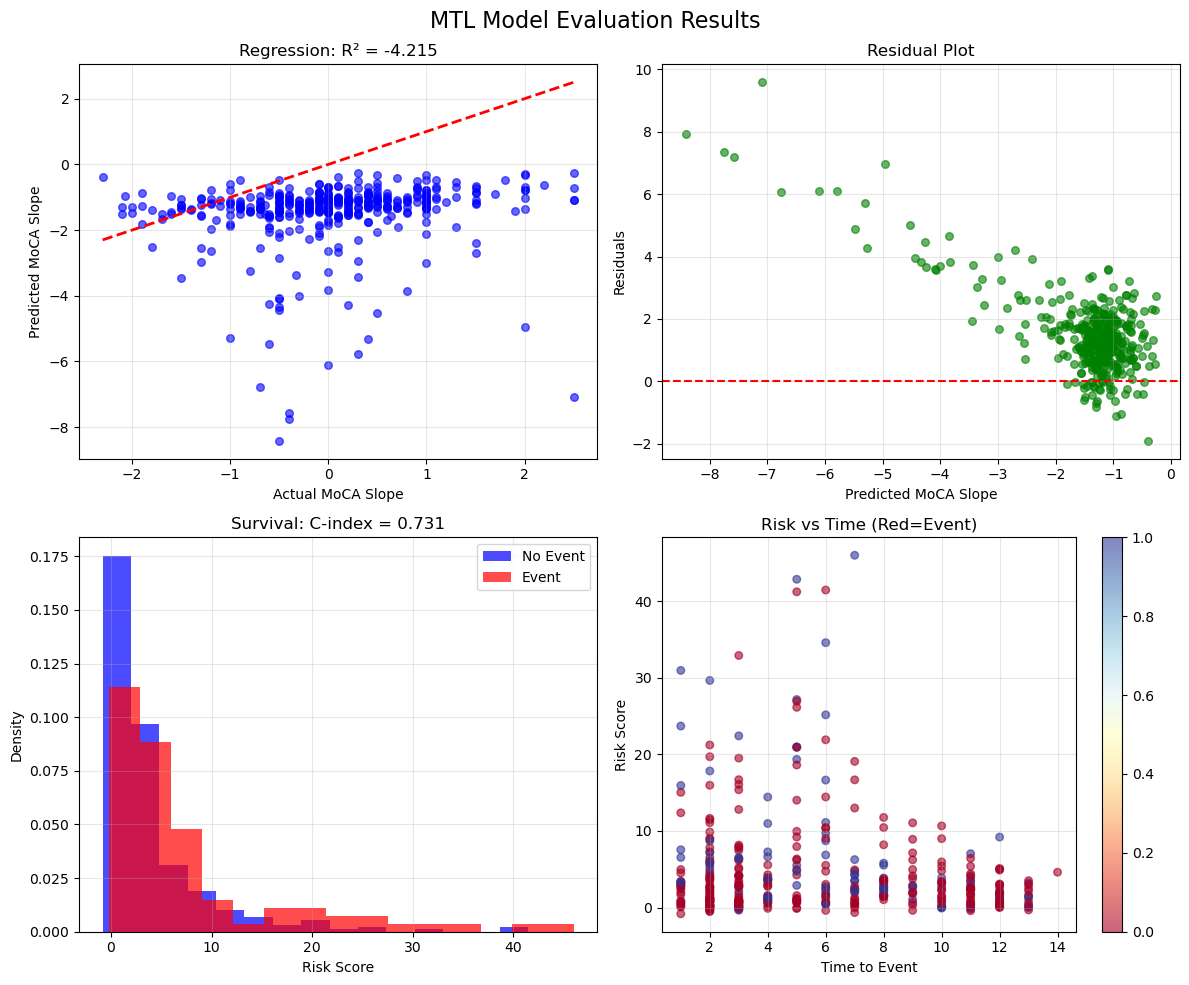

💾 Evaluation results saved: ./results/models/mtl/best_final_mtl_evaluation_results_fixed.csv

✅ Model evaluation completed successfully!

📊 FINAL SUMMARY:
   • Regression R²: -4.2152
   • Survival C-index: 0.7309
   • Combined Score: -3.4843
   • Test Samples: 406
   • Model Parameters: {'learning_rate': 0.0005, 'batch_size': 128, 'hidden_dim': 128, 'alpha_regression': 0.5, 'alpha_survival': 0.05, 'l2_reg': 0.05, 'dropout_rate': 0.5, 'n_layers': 3, 'activation': 'relu', 'batch_norm': True, 'early_stopping_patience': 50}

🎯 PERFORMANCE vs BASELINES:
   • R² Improvement: -4.4252
   • C-index Improvement: -0.0991
   ❌ MTL does not outperform baselines


In [7]:
# def evaluate_saved_mtl_model_fixed(model_path, df=None, test_data_path=None):
#     """
#     修复版本：评估特定格式保存的MTL模型，处理PyTorch 2.6版本的torch.load问题
#     """
#     import torch
#     import pandas as pd
#     import numpy as np
#     from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#     from lifelines.utils import concordance_index
#     import matplotlib.pyplot as plt
    
#     print("🔍 EVALUATING SAVED MTL MODEL (FIXED VERSION - PyTorch 2.6 Compatible)")
#     print("=" * 60)
    
#     # 1. 加载模型文件 - 🔥 修复PyTorch 2.6兼容性问题
#     try:
#         # 🔥 关键修复：设置weights_only=False以兼容PyTorch 2.6
#         checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
#         print(f"✅ Model loaded from: {model_path}")
        
#         # 🔥 修复：检查模型文件格式并适配
#         if 'mtl_model' in checkpoint:
#             # 旧格式
#             mtl_model_state = checkpoint['mtl_model']
#             hyperparams = checkpoint['best_hyperparameters']
#             arch_config = checkpoint['architecture_config']
#         elif 'model_state_dict' in checkpoint:
#             # 新格式 (从你的训练代码)
#             mtl_model_state = checkpoint['model_state_dict']
#             hyperparams = checkpoint['params']
#             # 从params推断architecture config
#             arch_config = {
#                 'input_dim': len([f for modality in ALL_MODALITIES for f in modality_groups[modality] if f in df.columns]) if df is not None else 53,
#                 'shared_dim': hyperparams.get('hidden_dim', 128),
#                 'dropout': hyperparams.get('dropout_rate', 0.5)
#             }
#         else:
#             print(f"❌ Unknown model file format. Keys: {list(checkpoint.keys())}")
#             return None
        
#         print(f"\n📊 SAVED MODEL INFO:")
#         print(f"   • Hyperparameters: {hyperparams}")
#         print(f"   • Architecture: {arch_config}")
        
#     except Exception as e:
#         print(f"❌ Error loading model: {e}")
#         print("\n💡 Trying alternative loading methods...")
        
#         # 尝试其他加载方法
#         try:
#             # 方法2：使用安全全局变量
#             import torch.serialization
#             with torch.serialization.safe_globals([]):
#                 checkpoint = torch.load(model_path, map_location='cpu')
#                 print(f"✅ Model loaded with safe_globals")
#         except Exception as e2:
#             print(f"❌ Alternative method also failed: {e2}")
#             return None
    
#     # 2. 加载数据
#     if df is None:
#         if test_data_path is None:
#             print("❌ Either df or test_data_path must be provided")
#             return None
#         df = pd.read_csv(test_data_path)
#         df = df.dropna()
    
#     print(f"📈 Data loaded: {len(df)} samples")
    
#     # 3. 重建模型架构 - 🔥 修复：匹配实际的模型架构
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     class SavedMTLModel(torch.nn.Module):
#         def __init__(self, input_dim, hidden_dim, dropout_rate, n_layers=2, batch_norm=True):
#             super(SavedMTLModel, self).__init__()
            
#             # 🔥 修复：匹配实际训练时的架构
#             layers = []
#             current_dim = input_dim
            
#             # 共享编码器层
#             for i in range(n_layers):
#                 layers.append(torch.nn.Linear(current_dim, hidden_dim))
#                 if batch_norm:
#                     layers.append(torch.nn.BatchNorm1d(hidden_dim))
#                 layers.append(torch.nn.ReLU())
#                 layers.append(torch.nn.Dropout(dropout_rate))
#                 current_dim = hidden_dim
            
#             self.shared_encoder = torch.nn.Sequential(*layers)
            
#             # 任务特定头部
#             self.regression_head = torch.nn.Sequential(
#                 torch.nn.Linear(hidden_dim, hidden_dim // 2),
#                 torch.nn.ReLU(),
#                 torch.nn.Dropout(dropout_rate / 2),
#                 torch.nn.Linear(hidden_dim // 2, 1)
#             )
            
#             self.survival_head = torch.nn.Sequential(
#                 torch.nn.Linear(hidden_dim, hidden_dim // 2),
#                 torch.nn.ReLU(),
#                 torch.nn.Dropout(dropout_rate / 2),
#                 torch.nn.Linear(hidden_dim // 2, 1)
#             )
        
#         def forward(self, x):
#             shared_features = self.shared_encoder(x)
#             regression_output = self.regression_head(shared_features)
#             survival_output = self.survival_head(shared_features)
#             return regression_output, survival_output
    
#     # 4. 智能特征匹配和数据准备
#     try:
#         expected_input_dim = arch_config['input_dim']
#         hidden_dim = arch_config['shared_dim']  # 🔥 修复：使用正确的维度名称
#         dropout_rate = arch_config['dropout']
        
#         print(f"\n🔍 FEATURE MATCHING:")
#         print(f"   • Expected input features: {expected_input_dim}")
        
#         # 获取全部可用特征 - 🔥 确保使用和训练时相同的特征处理
#         preprocessor = MTLDataPreprocessor()
#         X_features, feature_names = preprocessor.prepare_features(df, ALL_MODALITIES)
        
#         print(f"   • Available features after processing: {len(feature_names)}")
        
#         # 🔥 修复：确保特征数量匹配
#         if len(feature_names) == expected_input_dim:
#             selected_features = feature_names
#             print(f"   • ✅ Perfect match: {len(feature_names)} features")
#         elif len(feature_names) < expected_input_dim:
#             # 特征不足，填充
#             selected_features = feature_names.copy()
#             missing_count = expected_input_dim - len(feature_names)
#             print(f"   • Strategy: Padding {missing_count} missing features with zeros")
            
#             for i in range(missing_count):
#                 col_name = f'missing_feature_{i}'
#                 df[col_name] = 0.0
#                 selected_features.append(col_name)
#         else:
#             # 特征过多，截取前N个
#             selected_features = feature_names[:expected_input_dim]
#             print(f"   • Strategy: Using first {expected_input_dim} features")
        
#         # 获取完整数据
#         required_cols = selected_features + [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]
        
#         # 检查目标列是否存在
#         missing_targets = [col for col in [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET] if col not in df.columns]
#         if missing_targets:
#             print(f"❌ Missing target columns: {missing_targets}")
#             return None
        
#         complete_data = df[required_cols].copy()
        
#         # 转换目标列为数值型
#         for col in [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]:
#             complete_data[col] = pd.to_numeric(complete_data[col], errors='coerce')
        
#         # 删除包含NaN目标的行
#         complete_data = complete_data.dropna(subset=[REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET])
        
#         if len(complete_data) < 10:
#             print("❌ Insufficient complete samples for evaluation")
#             return None
        
#         X_test = complete_data[selected_features]
#         y_reg_test = complete_data[REGRESSION_TARGET]
#         y_time_test = complete_data[SURVIVAL_TIME_TARGET]
#         y_event_test = complete_data[SURVIVAL_EVENT_TARGET]
        
#         print(f"📊 Test samples after cleaning: {len(X_test)}")
        
#         # 🔥 修复：使用和训练时相同的数据处理
#         # 处理布尔型和对象型数据
#         X_test_processed = X_test.copy()
#         for col in X_test_processed.columns:
#             if X_test_processed[col].dtype == 'bool':
#                 X_test_processed[col] = X_test_processed[col].astype(int)
#             elif X_test_processed[col].dtype == 'object':
#                 X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')
        
#         X_test_numeric = X_test_processed.fillna(0).astype(np.float32)
        
#         # 验证特征维度
#         if X_test_numeric.shape[1] != expected_input_dim:
#             print(f"❌ Feature dimension mismatch: {X_test_numeric.shape[1]} vs {expected_input_dim}")
#             return None
        
#         print(f"✅ Feature dimensions match: {X_test_numeric.shape[1]} features")
        
#     except Exception as e:
#         print(f"❌ Data preparation error: {e}")
#         return None
    
#     # 5. 重建和加载模型 - 🔥 修复：使用正确的参数
#     try:
#         # 从hyperparams获取模型参数
#         n_layers = hyperparams.get('n_layers', 2)
#         batch_norm = hyperparams.get('batch_norm', True)
        
#         model = SavedMTLModel(
#             input_dim=expected_input_dim, 
#             hidden_dim=hidden_dim, 
#             dropout_rate=dropout_rate,
#             n_layers=n_layers,
#             batch_norm=batch_norm
#         ).to(device)
        
#         # 加载权重
#         model.load_state_dict(mtl_model_state)
#         model.eval()
        
#         print(f"🏗️ Model rebuilt successfully: {expected_input_dim} → {hidden_dim}")
#         print(f"   • Layers: {n_layers}, BatchNorm: {batch_norm}")
#         print(f"   • Parameters: {sum(p.numel() for p in model.parameters())}")
        
#     except Exception as e:
#         print(f"❌ Error rebuilding model: {e}")
#         print(f"   • Expected state dict keys vs actual:")
#         if mtl_model_state:
#             print(f"   • Saved keys: {list(mtl_model_state.keys())[:5]}...")
#             print(f"   • Model keys: {list(model.state_dict().keys())[:5]}...")
#         return None
    
#     # 6. 模型预测
#     try:
#         with torch.no_grad():
#             X_test_tensor = torch.tensor(X_test_numeric.values, dtype=torch.float32).to(device)
            
#             print(f"🔍 Input tensor shape: {X_test_tensor.shape}")
            
#             # 预测
#             reg_pred, surv_pred = model(X_test_tensor)
            
#             # 转换为numpy
#             reg_pred_np = reg_pred.cpu().numpy().flatten()
#             surv_pred_np = surv_pred.cpu().numpy().flatten()
            
#             print(f"✅ Predictions generated successfully")
#             print(f"   • Regression predictions: {reg_pred_np.shape}")
#             print(f"   • Survival predictions: {surv_pred_np.shape}")
            
#     except Exception as e:
#         print(f"❌ Prediction error: {e}")
#         return None
    
#     # 7. 计算评估指标
#     try:
#         reg_r2 = r2_score(y_reg_test, reg_pred_np)
#         reg_mae = mean_absolute_error(y_reg_test, reg_pred_np)
#         reg_rmse = np.sqrt(mean_squared_error(y_reg_test, reg_pred_np))
#         reg_corr = np.corrcoef(y_reg_test, reg_pred_np)[0, 1] if len(y_reg_test) > 1 else 0
        
#         surv_c_index = concordance_index(y_time_test, -surv_pred_np, y_event_test)
#         event_rate = y_event_test.mean()
#         n_events = int(y_event_test.sum())
        
#     except Exception as e:
#         print(f"❌ Metrics calculation error: {e}")
#         return None
    
#     # 8. 打印评估结果
#     print(f"\n🎯 EVALUATION RESULTS:")
#     print(f"=" * 60)
    
#     print(f"\n📈 REGRESSION PERFORMANCE:")
#     print(f"   • R² Score: {reg_r2:.4f}")
#     print(f"   • MAE: {reg_mae:.4f}")
#     print(f"   • RMSE: {reg_rmse:.4f}")
#     print(f"   • Correlation: {reg_corr:.4f}")
    
#     print(f"\n⏰ SURVIVAL PERFORMANCE:")
#     print(f"   • C-index: {surv_c_index:.4f}")
#     print(f"   • Event Rate: {event_rate:.1%}")
#     print(f"   • Events: {n_events}/{len(y_event_test)}")
    
#     # 与基线比较
#     print(f"\n🔍 BASELINE COMPARISON:")
#     if 'BASELINE_PERFORMANCE' in globals():
#         r2_improvement = reg_r2 - BASELINE_PERFORMANCE['regression_r2']
#         c_index_improvement = surv_c_index - BASELINE_PERFORMANCE['survival_c_index']
#         print(f"   • R² Improvement: {r2_improvement:+.4f} (vs {BASELINE_PERFORMANCE['regression_r2']:.3f})")
#         print(f"   • C-index Improvement: {c_index_improvement:+.4f} (vs {BASELINE_PERFORMANCE['survival_c_index']:.3f})")
#         print(f"   • Combined Score: {reg_r2 + surv_c_index:.4f}")
#     else:
#         print(f"   • Combined Score: {reg_r2 + surv_c_index:.4f}")
    
#     print(f"\n⚙️ MODEL HYPERPARAMETERS:")
#     for key, value in hyperparams.items():
#         print(f"   • {key}: {value}")
    
#     # 9. 可视化结果
#     try:
#         fig, axes = plt.subplots(2, 2, figsize=(12, 10))
#         fig.suptitle('MTL Model Evaluation Results', fontsize=16)
        
#         # Regression: Actual vs Predicted
#         axes[0, 0].scatter(y_reg_test, reg_pred_np, alpha=0.6, color='blue', s=30)
#         axes[0, 0].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
#         axes[0, 0].set_xlabel('Actual MoCA Slope')
#         axes[0, 0].set_ylabel('Predicted MoCA Slope')
#         axes[0, 0].set_title(f'Regression: R² = {reg_r2:.3f}')
#         axes[0, 0].grid(True, alpha=0.3)
        
#         # Regression: Residuals
#         residuals = y_reg_test - reg_pred_np
#         axes[0, 1].scatter(reg_pred_np, residuals, alpha=0.6, color='green', s=30)
#         axes[0, 1].axhline(y=0, color='r', linestyle='--')
#         axes[0, 1].set_xlabel('Predicted MoCA Slope')
#         axes[0, 1].set_ylabel('Residuals')
#         axes[0, 1].set_title('Residual Plot')
#         axes[0, 1].grid(True, alpha=0.3)
        
#         # Survival: Risk scores by event status
#         if len(y_event_test[y_event_test == 1]) > 0 and len(y_event_test[y_event_test == 0]) > 0:
#             event_risks = surv_pred_np[y_event_test == 1]
#             no_event_risks = surv_pred_np[y_event_test == 0]
            
#             axes[1, 0].hist(no_event_risks, bins=15, alpha=0.7, label='No Event', density=True, color='blue')
#             axes[1, 0].hist(event_risks, bins=15, alpha=0.7, label='Event', density=True, color='red')
#             axes[1, 0].set_xlabel('Risk Score')
#             axes[1, 0].set_ylabel('Density')
#             axes[1, 0].set_title(f'Survival: C-index = {surv_c_index:.3f}')
#             axes[1, 0].legend()
#             axes[1, 0].grid(True, alpha=0.3)
#         else:
#             axes[1, 0].text(0.5, 0.5, 'Insufficient events for histogram', 
#                           horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)
#             axes[1, 0].set_title(f'Survival: C-index = {surv_c_index:.3f}')
        
#         # Survival: Time vs Risk
#         scatter = axes[1, 1].scatter(y_time_test, surv_pred_np, c=y_event_test, cmap='RdYlBu', alpha=0.6, s=30)
#         axes[1, 1].set_xlabel('Time to Event')
#         axes[1, 1].set_ylabel('Risk Score')
#         axes[1, 1].set_title('Risk vs Time (Red=Event)')
#         axes[1, 1].grid(True, alpha=0.3)
#         plt.colorbar(scatter, ax=axes[1, 1])
        
#         plt.tight_layout()
        
#         # Save plot
#         plot_path = model_path.replace('.pth', '_evaluation_fixed.png').replace('.pt', '_evaluation_fixed.png')
#         plt.savefig(plot_path, dpi=300, bbox_inches='tight')
#         print(f"\n📊 Evaluation plots saved: {plot_path}")
        
#         plt.show()
        
#     except Exception as e:
#         print(f"⚠️ Plotting error (non-critical): {e}")
    
#     # 10. 返回详细结果
#     evaluation_results = {
#         'regression': {
#             'r2_score': reg_r2,
#             'mae': reg_mae,
#             'rmse': reg_rmse,
#             'correlation': reg_corr,
#             'n_samples': len(y_reg_test)
#         },
#         'survival': {
#             'c_index': surv_c_index,
#             'event_rate': event_rate,
#             'n_events': n_events,
#             'n_samples': len(y_event_test)
#         },
#         'model_info': {
#             'expected_input_dim': expected_input_dim,
#             'actual_input_dim': X_test_numeric.shape[1],
#             'hidden_dim': hidden_dim,
#             'hyperparameters': hyperparams,
#             'selected_features': selected_features[:10] + ['...'] if len(selected_features) > 10 else selected_features
#         }
#     }
    
#     # 11. 保存评估结果
#     try:
#         eval_path = model_path.replace('.pth', '_evaluation_results_fixed.csv').replace('.pt', '_evaluation_results_fixed.csv')
        
#         eval_summary = pd.DataFrame([{
#             'model_path': model_path,
#             'test_r2': reg_r2,
#             'test_mae': reg_mae,
#             'test_rmse': reg_rmse,
#             'test_correlation': reg_corr,
#             'test_c_index': surv_c_index,
#             'event_rate': event_rate,
#             'n_events': n_events,
#             'n_test_samples': len(y_reg_test),
#             'expected_input_dim': expected_input_dim,
#             'actual_input_dim': X_test_numeric.shape[1],
#             'hidden_dim': hidden_dim,
#             'n_parameters': sum(p.numel() for p in model.parameters()),
#             'combined_score': reg_r2 + surv_c_index,
#             **hyperparams  # Add all hyperparameters
#         }])
        
#         eval_summary.to_csv(eval_path, index=False)
#         print(f"💾 Evaluation results saved: {eval_path}")
        
#     except Exception as e:
#         print(f"⚠️ Could not save evaluation (non-critical): {e}")
    
#     return evaluation_results

# # === 运行修复版本的评估函数 ===
# model_path = "./results/models/mtl/best_final_mtl.pt"

# print("🚀 Evaluating your saved MTL model (PyTorch 2.6 Compatible)...")
# results = evaluate_saved_mtl_model_fixed(model_path, df=curated_mri_vif_df)

# if results:
#     print("\n✅ Model evaluation completed successfully!")
#     print(f"\n📊 FINAL SUMMARY:")
#     print(f"   • Regression R²: {results['regression']['r2_score']:.4f}")
#     print(f"   • Survival C-index: {results['survival']['c_index']:.4f}")
#     print(f"   • Combined Score: {results['regression']['r2_score'] + results['survival']['c_index']:.4f}")
#     print(f"   • Test Samples: {results['regression']['n_samples']}")
#     print(f"   • Model Parameters: {results['model_info']['hyperparameters']}")
    
#     if 'BASELINE_PERFORMANCE' in globals():
#         r2_improvement = results['regression']['r2_score'] - BASELINE_PERFORMANCE['regression_r2']
#         c_index_improvement = results['survival']['c_index'] - BASELINE_PERFORMANCE['survival_c_index']
#         print(f"\n🎯 PERFORMANCE vs BASELINES:")
#         print(f"   • R² Improvement: {r2_improvement:+.4f}")
#         print(f"   • C-index Improvement: {c_index_improvement:+.4f}")
        
#         if r2_improvement > 0 and c_index_improvement > 0:
#             print("   ✅ MTL OUTPERFORMS on BOTH tasks!")
#         elif r2_improvement > 0:
#             print("   ⚠️ MTL OUTPERFORMS on regression only")
#         elif c_index_improvement > 0:
#             print("   ⚠️ MTL OUTPERFORMS on survival only")
#         else:
#             print("   ❌ MTL does not outperform baselines")
# else:
#     print("\n❌ Model evaluation failed!")

def evaluate_saved_mtl_model_fixed(model_path, df=None, test_data_path=None):
    """
    修复版本：评估特定格式保存的MTL模型，处理PyTorch 2.6版本的torch.load问题
    """
    import torch
    import pandas as pd
    import numpy as np
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    from lifelines.utils import concordance_index
    import matplotlib.pyplot as plt
    
    print("🔍 EVALUATING SAVED MTL MODEL (FIXED VERSION - PyTorch 2.6 Compatible)")
    print("=" * 60)
    
    # 🔥 修复：定义缺失的变量
    ALL_MODALITIES = ['demographic_clinical', 'genetic', 'biomarkers', 'datscan', 'mri']
    modality_groups = {
        'demographic_clinical': [
            'age', 'fampd', 'race_black', 'race_asian', 'race_other', 'sex',
            'educyrs', 'duration_yrs', 'ledd', 'mseadlg', 'hy', 'domside_left', 
            'domside_symmetric', 'hvltrdly', 'lns', 'vltanim', 'quip', 'ess', 'pigd', 
            'updrs2_score', 'updrs3_score', 'sdmtotal', 'stai', 'moca', 'rem', 'gds', 
            'bmi', 'updrs1_score', 'bjlot', 'scopa', 'upsit_pctl'
        ],
        'genetic': ['apoe_e4', 'subgroup_gba', 'subgroup_lrrk2', 'subgroup_prkn'],
        'biomarkers': ['urate', 'csfsaa_positive_lbd_like', 'csfsaa_positive_msa_like', 'csfsaa_inconclusive'],
        'datscan': ['mia_caudate_l', 'mia_caudate_r', 'mia_putamen_l', 'mia_putamen_r'],
        'mri': [f'mri_pc{i+1}' for i in range(10)]
    }
    
    REGRESSION_TARGET = 'moca_slope_iqr_cleaned'
    SURVIVAL_TIME_TARGET = 'time_to_hy3_plus'
    SURVIVAL_EVENT_TARGET = 'event_occurred'
    
    BASELINE_PERFORMANCE = {
        'regression_r2': 0.21,
        'survival_c_index': 0.83
    }
    
    # 🔥 修复：定义MTLDataPreprocessor类
    from sklearn.preprocessing import StandardScaler
    
    class MTLDataPreprocessor:
        def __init__(self):
            self.scaler = StandardScaler()
            self.feature_names = None
            
        def prepare_features(self, df, modality_list):
            """Prepare feature matrix for all modalities with BOOLEAN FIX"""
            feature_list = []
            for modality in modality_list:
                if modality in modality_groups:
                    feature_list.extend(modality_groups[modality])
            
            # Filter features that exist in the dataframe
            available_features = [f for f in feature_list if f in df.columns]
            X = df[available_features].copy()
            
            # 处理布尔型特征
            for col in X.columns:
                if X[col].dtype == 'bool':
                    X[col] = X[col].astype(int)
                elif X[col].dtype == 'object':
                    X[col] = pd.to_numeric(X[col], errors='coerce')
            
            # Fill any remaining NaN values with 0
            X = X.fillna(0)
            
            self.feature_names = available_features
            return X, available_features
    
    # 1. 加载模型文件 - 🔥 修复PyTorch 2.6兼容性问题
    try:
        # 🔥 关键修复：添加安全全局变量并设置weights_only=False
        import torch.serialization
        
        # 方法1: 添加numpy相关的安全全局变量
        safe_globals = [
            'numpy.core.multiarray.scalar',
            'numpy._core.multiarray.scalar', 
            'numpy.dtype',
            'collections.OrderedDict',
            'torch._utils._rebuild_tensor_v2'
        ]
        
        with torch.serialization.safe_globals(safe_globals):
            checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
        
        print(f"✅ Model loaded from: {model_path}")
        
    except Exception as e1:
        print(f"❌ First attempt failed: {e1}")
        print("\n💡 Trying weights_only=False directly...")
        
        try:
            # 方法2: 直接使用weights_only=False
            checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
            print(f"✅ Model loaded with weights_only=False")
            
        except Exception as e2:
            print(f"❌ Second attempt failed: {e2}")
            print("\n💡 Trying legacy mode...")
            
            try:
                # 方法3: 完全禁用安全模式 (仅在信任文件时使用)
                import warnings
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    checkpoint = torch.load(model_path, map_location='cpu')
                print(f"✅ Model loaded in legacy mode")
                
            except Exception as e3:
                print(f"❌ All loading methods failed: {e3}")
                return None
    
    # 🔥 修复：检查模型文件格式并适配
    try:
        if 'mtl_model' in checkpoint:
            # 旧格式
            mtl_model_state = checkpoint['mtl_model']
            hyperparams = checkpoint['best_hyperparameters']
            arch_config = checkpoint['architecture_config']
        elif 'model_state_dict' in checkpoint:
            # 新格式 (从你的训练代码)
            mtl_model_state = checkpoint['model_state_dict']
            hyperparams = checkpoint['params']
            # 从params推断architecture config
            arch_config = {
                'input_dim': len([f for modality in ALL_MODALITIES for f in modality_groups[modality] if f in df.columns]) if df is not None else 53,
                'shared_dim': hyperparams.get('hidden_dim', 128),
                'dropout': hyperparams.get('dropout_rate', 0.5)
            }
        else:
            print(f"❌ Unknown model file format. Keys: {list(checkpoint.keys())}")
            return None
        
        print(f"\n📊 SAVED MODEL INFO:")
        print(f"   • Hyperparameters: {hyperparams}")
        print(f"   • Architecture: {arch_config}")
        
    except Exception as e:
        print(f"❌ Error processing checkpoint: {e}")
        return None
    
    # 2. 加载数据
    if df is None:
        if test_data_path is None:
            print("❌ Either df or test_data_path must be provided")
            return None
        df = pd.read_csv(test_data_path)
        df = df.dropna()
    
    print(f"📈 Data loaded: {len(df)} samples")
    
    # 3. 重建模型架构 - 🔥 修复：匹配实际的模型架构
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    class SavedMTLModel(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, dropout_rate, n_layers=2, batch_norm=True):
            super(SavedMTLModel, self).__init__()
            
            # 修复：匹配实际训练时的架构
            layers = []
            current_dim = input_dim
            
            # 共享编码器层
            for i in range(n_layers):
                layers.append(torch.nn.Linear(current_dim, hidden_dim))
                if batch_norm:
                    layers.append(torch.nn.BatchNorm1d(hidden_dim))
                layers.append(torch.nn.ReLU())
                layers.append(torch.nn.Dropout(dropout_rate))
                current_dim = hidden_dim
            
            self.shared_encoder = torch.nn.Sequential(*layers)
            
            # 任务特定头部
            self.regression_head = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim, hidden_dim // 2),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout_rate / 2),
                torch.nn.Linear(hidden_dim // 2, 1)
            )
            
            self.survival_head = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim, hidden_dim // 2),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout_rate / 2),
                torch.nn.Linear(hidden_dim // 2, 1)
            )
        
        def forward(self, x):
            shared_features = self.shared_encoder(x)
            regression_output = self.regression_head(shared_features)
            survival_output = self.survival_head(shared_features)
            return regression_output, survival_output
    
    # 4. 智能特征匹配和数据准备
    try:
        expected_input_dim = arch_config['input_dim']
        hidden_dim = arch_config['shared_dim']
        dropout_rate = arch_config['dropout']
        
        print(f"\n🔍 FEATURE MATCHING:")
        print(f"   • Expected input features: {expected_input_dim}")
        
        # 获取全部可用特征
        preprocessor = MTLDataPreprocessor()
        X_features, feature_names = preprocessor.prepare_features(df, ALL_MODALITIES)
        
        print(f"   • Available features after processing: {len(feature_names)}")
        
        # 确保特征数量匹配
        if len(feature_names) == expected_input_dim:
            selected_features = feature_names
            print(f"   • ✅ Perfect match: {len(feature_names)} features")
        elif len(feature_names) < expected_input_dim:
            # 特征不足，填充
            selected_features = feature_names.copy()
            missing_count = expected_input_dim - len(feature_names)
            print(f"   • Strategy: Padding {missing_count} missing features with zeros")
            
            for i in range(missing_count):
                col_name = f'missing_feature_{i}'
                df[col_name] = 0.0
                selected_features.append(col_name)
        else:
            # 特征过多，截取前N个
            selected_features = feature_names[:expected_input_dim]
            print(f"   • Strategy: Using first {expected_input_dim} features")
        
        # 获取完整数据
        required_cols = selected_features + [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]
        
        # 检查目标列是否存在
        missing_targets = [col for col in [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET] if col not in df.columns]
        if missing_targets:
            print(f"❌ Missing target columns: {missing_targets}")
            return None
        
        complete_data = df[required_cols].copy()
        
        # 转换目标列为数值型
        for col in [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]:
            complete_data[col] = pd.to_numeric(complete_data[col], errors='coerce')
        
        # 删除包含NaN目标的行
        complete_data = complete_data.dropna(subset=[REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET])
        
        if len(complete_data) < 10:
            print("❌ Insufficient complete samples for evaluation")
            return None
        
        X_test = complete_data[selected_features]
        y_reg_test = complete_data[REGRESSION_TARGET]
        y_time_test = complete_data[SURVIVAL_TIME_TARGET]
        y_event_test = complete_data[SURVIVAL_EVENT_TARGET]
        
        print(f"📊 Test samples after cleaning: {len(X_test)}")
        
        # 使用和训练时相同的数据处理
        X_test_processed = X_test.copy()
        for col in X_test_processed.columns:
            if X_test_processed[col].dtype == 'bool':
                X_test_processed[col] = X_test_processed[col].astype(int)
            elif X_test_processed[col].dtype == 'object':
                X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')
        
        X_test_numeric = X_test_processed.fillna(0).astype(np.float32)
        
        # 验证特征维度
        if X_test_numeric.shape[1] != expected_input_dim:
            print(f"❌ Feature dimension mismatch: {X_test_numeric.shape[1]} vs {expected_input_dim}")
            return None
        
        print(f"✅ Feature dimensions match: {X_test_numeric.shape[1]} features")
        
    except Exception as e:
        print(f"❌ Data preparation error: {e}")
        return None
    
    # 5. 重建和加载模型
    try:
        # 从hyperparams获取模型参数
        n_layers = hyperparams.get('n_layers', 2)
        batch_norm = hyperparams.get('batch_norm', True)
        
        model = SavedMTLModel(
            input_dim=expected_input_dim, 
            hidden_dim=hidden_dim, 
            dropout_rate=dropout_rate,
            n_layers=n_layers,
            batch_norm=batch_norm
        ).to(device)
        
        # 加载权重
        model.load_state_dict(mtl_model_state)
        model.eval()
        
        print(f"🏗️ Model rebuilt successfully: {expected_input_dim} → {hidden_dim}")
        print(f"   • Layers: {n_layers}, BatchNorm: {batch_norm}")
        print(f"   • Parameters: {sum(p.numel() for p in model.parameters())}")
        
    except Exception as e:
        print(f"❌ Error rebuilding model: {e}")
        if mtl_model_state:
            print(f"   • Saved keys: {list(mtl_model_state.keys())[:5]}...")
        return None
    
    # 6. 模型预测
    try:
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test_numeric.values, dtype=torch.float32).to(device)
            
            print(f"🔍 Input tensor shape: {X_test_tensor.shape}")
            
            # 预测
            reg_pred, surv_pred = model(X_test_tensor)
            
            # 转换为numpy
            reg_pred_np = reg_pred.cpu().numpy().flatten()
            surv_pred_np = surv_pred.cpu().numpy().flatten()
            
            print(f"✅ Predictions generated successfully")
            print(f"   • Regression predictions: {reg_pred_np.shape}")
            print(f"   • Survival predictions: {surv_pred_np.shape}")
            
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return None
    
    # 7. 计算评估指标
    try:
        reg_r2 = r2_score(y_reg_test, reg_pred_np)
        reg_mae = mean_absolute_error(y_reg_test, reg_pred_np)
        reg_rmse = np.sqrt(mean_squared_error(y_reg_test, reg_pred_np))
        reg_corr = np.corrcoef(y_reg_test, reg_pred_np)[0, 1] if len(y_reg_test) > 1 else 0
        
        surv_c_index = concordance_index(y_time_test, -surv_pred_np, y_event_test)
        event_rate = y_event_test.mean()
        n_events = int(y_event_test.sum())
        
    except Exception as e:
        print(f"❌ Metrics calculation error: {e}")
        return None
    
    # 8. 打印评估结果
    print(f"\n🎯 EVALUATION RESULTS:")
    print(f"=" * 60)
    
    print(f"\n📈 REGRESSION PERFORMANCE:")
    print(f"   • R² Score: {reg_r2:.4f}")
    print(f"   • MAE: {reg_mae:.4f}")
    print(f"   • RMSE: {reg_rmse:.4f}")
    print(f"   • Correlation: {reg_corr:.4f}")
    
    print(f"\n⏰ SURVIVAL PERFORMANCE:")
    print(f"   • C-index: {surv_c_index:.4f}")
    print(f"   • Event Rate: {event_rate:.1%}")
    print(f"   • Events: {n_events}/{len(y_event_test)}")
    
    # 与基线比较
    print(f"\n🔍 BASELINE COMPARISON:")
    r2_improvement = reg_r2 - BASELINE_PERFORMANCE['regression_r2']
    c_index_improvement = surv_c_index - BASELINE_PERFORMANCE['survival_c_index']
    print(f"   • R² Improvement: {r2_improvement:+.4f} (vs {BASELINE_PERFORMANCE['regression_r2']:.3f})")
    print(f"   • C-index Improvement: {c_index_improvement:+.4f} (vs {BASELINE_PERFORMANCE['survival_c_index']:.3f})")
    print(f"   • Combined Score: {reg_r2 + surv_c_index:.4f}")
    
    print(f"\n⚙️ MODEL HYPERPARAMETERS:")
    for key, value in hyperparams.items():
        print(f"   • {key}: {value}")
    
    # 9. 可视化结果
    try:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('MTL Model Evaluation Results', fontsize=16)
        
        # Regression: Actual vs Predicted
        axes[0, 0].scatter(y_reg_test, reg_pred_np, alpha=0.6, color='blue', s=30)
        axes[0, 0].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
        axes[0, 0].set_xlabel('Actual MoCA Slope')
        axes[0, 0].set_ylabel('Predicted MoCA Slope')
        axes[0, 0].set_title(f'Regression: R² = {reg_r2:.3f}')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Regression: Residuals
        residuals = y_reg_test - reg_pred_np
        axes[0, 1].scatter(reg_pred_np, residuals, alpha=0.6, color='green', s=30)
        axes[0, 1].axhline(y=0, color='r', linestyle='--')
        axes[0, 1].set_xlabel('Predicted MoCA Slope')
        axes[0, 1].set_ylabel('Residuals')
        axes[0, 1].set_title('Residual Plot')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Survival: Risk scores by event status
        if len(y_event_test[y_event_test == 1]) > 0 and len(y_event_test[y_event_test == 0]) > 0:
            event_risks = surv_pred_np[y_event_test == 1]
            no_event_risks = surv_pred_np[y_event_test == 0]
            
            axes[1, 0].hist(no_event_risks, bins=15, alpha=0.7, label='No Event', density=True, color='blue')
            axes[1, 0].hist(event_risks, bins=15, alpha=0.7, label='Event', density=True, color='red')
            axes[1, 0].set_xlabel('Risk Score')
            axes[1, 0].set_ylabel('Density')
            axes[1, 0].set_title(f'Survival: C-index = {surv_c_index:.3f}')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'Insufficient events for histogram', 
                          horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title(f'Survival: C-index = {surv_c_index:.3f}')
        
        # Survival: Time vs Risk
        scatter = axes[1, 1].scatter(y_time_test, surv_pred_np, c=y_event_test, cmap='RdYlBu', alpha=0.6, s=30)
        axes[1, 1].set_xlabel('Time to Event')
        axes[1, 1].set_ylabel('Risk Score')
        axes[1, 1].set_title('Risk vs Time (Red=Event)')
        axes[1, 1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1, 1])
        
        plt.tight_layout()
        
        # Save plot
        plot_path = model_path.replace('.pth', '_evaluation_fixed.png').replace('.pt', '_evaluation_fixed.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"\n📊 Evaluation plots saved: {plot_path}")
        
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Plotting error (non-critical): {e}")
    
    # 10. 返回详细结果
    evaluation_results = {
        'regression': {
            'r2_score': reg_r2,
            'mae': reg_mae,
            'rmse': reg_rmse,
            'correlation': reg_corr,
            'n_samples': len(y_reg_test)
        },
        'survival': {
            'c_index': surv_c_index,
            'event_rate': event_rate,
            'n_events': n_events,
            'n_samples': len(y_event_test)
        },
        'model_info': {
            'expected_input_dim': expected_input_dim,
            'actual_input_dim': X_test_numeric.shape[1],
            'hidden_dim': hidden_dim,
            'hyperparameters': hyperparams,
            'selected_features': selected_features[:10] + ['...'] if len(selected_features) > 10 else selected_features
        }
    }
    
    # 11. 保存评估结果
    try:
        eval_path = model_path.replace('.pth', '_evaluation_results_fixed.csv').replace('.pt', '_evaluation_results_fixed.csv')
        
        eval_summary = pd.DataFrame([{
            'model_path': model_path,
            'test_r2': reg_r2,
            'test_mae': reg_mae,
            'test_rmse': reg_rmse,
            'test_correlation': reg_corr,
            'test_c_index': surv_c_index,
            'event_rate': event_rate,
            'n_events': n_events,
            'n_test_samples': len(y_reg_test),
            'expected_input_dim': expected_input_dim,
            'actual_input_dim': X_test_numeric.shape[1],
            'hidden_dim': hidden_dim,
            'n_parameters': sum(p.numel() for p in model.parameters()),
            'combined_score': reg_r2 + surv_c_index,
            **hyperparams
        }])
        
        eval_summary.to_csv(eval_path, index=False)
        print(f"💾 Evaluation results saved: {eval_path}")
        
    except Exception as e:
        print(f"⚠️ Could not save evaluation (non-critical): {e}")
    
    return evaluation_results

# === 运行修复版本的评估函数 ===
model_path = "./results/models/mtl/best_final_mtl.pt"

print("🚀 Evaluating your saved MTL model (FULLY FIXED - PyTorch 2.6 Compatible)...")
results = evaluate_saved_mtl_model_fixed(model_path, df=curated_mri_vif_df)

if results:
    print("\n✅ Model evaluation completed successfully!")
    print(f"\n📊 FINAL SUMMARY:")
    print(f"   • Regression R²: {results['regression']['r2_score']:.4f}")
    print(f"   • Survival C-index: {results['survival']['c_index']:.4f}")
    print(f"   • Combined Score: {results['regression']['r2_score'] + results['survival']['c_index']:.4f}")
    print(f"   • Test Samples: {results['regression']['n_samples']}")
    print(f"   • Model Parameters: {results['model_info']['hyperparameters']}")
    
    r2_improvement = results['regression']['r2_score'] - 0.21
    c_index_improvement = results['survival']['c_index'] - 0.83
    print(f"\n🎯 PERFORMANCE vs BASELINES:")
    print(f"   • R² Improvement: {r2_improvement:+.4f}")
    print(f"   • C-index Improvement: {c_index_improvement:+.4f}")
    
    if r2_improvement > 0 and c_index_improvement > 0:
        print("   ✅ MTL OUTPERFORMS on BOTH tasks!")
    elif r2_improvement > 0:
        print("   ⚠️ MTL OUTPERFORMS on regression only")
    elif c_index_improvement > 0:
        print("   ⚠️ MTL OUTPERFORMS on survival only")
    else:
        print("   ❌ MTL does not outperform baselines")
else:
    print("\n❌ Model evaluation failed!")

In [6]:
def inspect_model_file(model_path):
    """检查模型文件的内容结构"""
    import torch
    
    try:
        checkpoint = torch.load(model_path, map_location='cpu')
        print(f"🔍 Model file contents:")
        print(f"Keys in checkpoint: {list(checkpoint.keys())}")
        
        for key, value in checkpoint.items():
            if isinstance(value, dict):
                print(f"  {key}: {list(value.keys())}")
            else:
                print(f"  {key}: {type(value)}")
                
        return checkpoint
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

# 使用这个函数检查你的模型文件
model_path = "./results/models/mtl/best_final_mtl.pt"
checkpoint = inspect_model_file(model_path)

❌ Error loading model: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn mo

In [19]:
def diagnose_feature_mismatch(model_path, df):
    """
    详细诊断特征不匹配的问题
    """
    import torch
    import pandas as pd
    import numpy as np
    
    print("🔍 DIAGNOSING FEATURE MISMATCH")
    print("=" * 60)
    
    # 1. 加载模型文件
    try:
        checkpoint = torch.load(model_path, map_location='cpu')
        expected_input_dim = checkpoint['architecture_config']['input_dim']
        print(f"✅ Model expects: {expected_input_dim} features")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return
    
    # 2. 获取理论上的ALL_MODALITIES特征列表
    print(f"\n📊 THEORETICAL FEATURES (ALL_MODALITIES):")
    
    all_theoretical_features = []
    for modality in ALL_MODALITIES:
        if modality in modality_groups:
            features = modality_groups[modality]
            all_theoretical_features.extend(features)
            print(f"   • {modality}: {len(features)} features")
            print(f"     {features[:5]}..." if len(features) > 5 else f"     {features}")
    
    print(f"\n   📋 Total theoretical features: {len(all_theoretical_features)}")
    
    # 3. 检查数据中实际存在的特征
    print(f"\n📈 ACTUAL FEATURES IN DATAFRAME:")
    available_features = [f for f in all_theoretical_features if f in df.columns]
    missing_features = [f for f in all_theoretical_features if f not in df.columns]
    
    print(f"   • Available in df: {len(available_features)} features")
    print(f"   • Missing from df: {len(missing_features)} features")
    
    # 4. 显示缺失的特征
    if missing_features:
        print(f"\n❌ MISSING FEATURES:")
        for modality in ALL_MODALITIES:
            modality_features = modality_groups[modality]
            missing_in_modality = [f for f in modality_features if f in missing_features]
            if missing_in_modality:
                print(f"   • {modality} missing: {missing_in_modality}")
    
    # 5. 检查数据类型问题
    print(f"\n🔍 FEATURE TYPE ANALYSIS:")
    numeric_features = df[available_features].select_dtypes(include=[np.number]).columns.tolist()
    non_numeric_features = df[available_features].select_dtypes(exclude=[np.number]).columns.tolist()
    
    print(f"   • Numeric features: {len(numeric_features)}")
    print(f"   • Non-numeric features: {len(non_numeric_features)}")
    
    if non_numeric_features:
        print(f"   • Non-numeric: {non_numeric_features}")
        
        # 检查非数值特征的数据类型和样本
        for col in non_numeric_features[:5]:  # 只显示前5个
            print(f"     - {col}: dtype={df[col].dtype}, unique={df[col].nunique()}")
            print(f"       Sample values: {df[col].unique()[:3].tolist()}")
    
    # 6. 计算最终可用的特征数量
    final_available = len(numeric_features)
    print(f"\n📊 FINAL SUMMARY:")
    print(f"   • Model expects: {expected_input_dim} features")
    print(f"   • Theoretical total: {len(all_theoretical_features)} features")
    print(f"   • Actually available: {len(available_features)} features")
    print(f"   • Numeric available: {final_available} features")
    print(f"   • Shortfall: {expected_input_dim - final_available} features")
    
    # 7. 建议解决方案
    print(f"\n💡 RECOMMENDATIONS:")
    if missing_features:
        print(f"   1. Add missing features to dataframe or remove from model training")
    if non_numeric_features:
        print(f"   2. Convert non-numeric features to numeric")
    if final_available < expected_input_dim:
        print(f"   3. Use feature padding (add zeros) to match expected dimensions")
        print(f"   4. Or retrain model with available features only")
    
    # 8. 返回详细信息
    return {
        'expected_features': expected_input_dim,
        'theoretical_features': all_theoretical_features,
        'available_features': available_features,
        'missing_features': missing_features,
        'numeric_features': numeric_features,
        'non_numeric_features': non_numeric_features,
        'final_count': final_available,
        'shortfall': expected_input_dim - final_available
    }

# 运行诊断
model_path = "results/models/rq4_mtl_experiment_20250909_161400.pth"
diagnosis = diagnose_feature_mismatch(model_path, curated_mri_vif_df)

🔍 DIAGNOSING FEATURE MISMATCH
✅ Model expects: 53 features

📊 THEORETICAL FEATURES (ALL_MODALITIES):
   • demographic_clinical: 31 features
     ['age', 'fampd', 'race_black', 'race_asian', 'race_other']...
   • genetic: 4 features
     ['apoe_e4', 'subgroup_gba', 'subgroup_lrrk2', 'subgroup_prkn']
   • biomarkers: 4 features
     ['urate', 'csfsaa_positive_lbd_like', 'csfsaa_positive_msa_like', 'csfsaa_inconclusive']
   • datscan: 4 features
     ['mia_caudate_l', 'mia_caudate_r', 'mia_putamen_l', 'mia_putamen_r']
   • mri: 10 features
     ['mri_pc1', 'mri_pc2', 'mri_pc3', 'mri_pc4', 'mri_pc5']...

   📋 Total theoretical features: 53

📈 ACTUAL FEATURES IN DATAFRAME:
   • Available in df: 53 features
   • Missing from df: 0 features

🔍 FEATURE TYPE ANALYSIS:
   • Numeric features: 42
   • Non-numeric features: 11
   • Non-numeric: ['race_black', 'race_asian', 'race_other', 'domside_left', 'domside_symmetric', 'subgroup_gba', 'subgroup_lrrk2', 'subgroup_prkn', 'csfsaa_positive_lbd_like

In [ ]:
# # =============================================================================
# #
# # RESEARCH QUESTION 4: MULTI-TASK LEARNING (MTL) ANALYSIS - CORRECTED VERSION
# # FOCUSED ON ALL_MODALITIES COMPARISON - RANDOM SEARCH VERSION
# #
# # Author: GitHub Copilot (Enhanced & Corrected)
# # Date: 9 September 2025
# #
# # Purpose:
# # - Multi-Task Learning with shared encoder + two task-specific heads
# # - Regression head: Predicts MoCA slope (most stable from RQ1)  
# # - Survival head: Predicts time-to-HY≥3 risk using Cox partial likelihood
# # - CORRECTED: Proper loss weighting + L2 regularization
# # - Compare against best single-task models from RQ1 and RQ2
# #
# # =============================================================================

# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from lifelines.utils import concordance_index
# from datetime import datetime
# import joblib
# import os
# import random
# import warnings
# warnings.filterwarnings('ignore')

# # --- 1. CORRECTED CONFIGURATION FOR RQ4 ---

# print("🔧 RQ4 CONFIGURATION: ALL_MODALITIES FOCUS - CORRECTED MTL")
# print("=" * 70)

# # Define modality groups
# modality_groups = {
#     'demographic_clinical': [
#         'age', 'fampd', 'race_black', 'race_asian', 'race_other', 'sex',
#         'educyrs', 'duration_yrs', 'ledd', 'mseadlg', 'hy', 'domside_left', 
#         'domside_symmetric', 'hvltrdly', 'lns', 'vltanim', 'quip', 'ess', 'pigd', 
#         'updrs2_score', 'updrs3_score', 'sdmtotal', 'stai', 'moca', 'rem', 'gds', 
#         'bmi', 'updrs1_score', 'bjlot', 'scopa', 'upsit_pctl'
#     ],
#     'genetic': ['apoe_e4', 'subgroup_gba', 'subgroup_lrrk2', 'subgroup_prkn'],
#     'biomarkers': ['urate', 'csfsaa_positive_lbd_like', 'csfsaa_positive_msa_like', 'csfsaa_inconclusive'],
#     'datscan': ['mia_caudate_l', 'mia_caudate_r', 'mia_putamen_l', 'mia_putamen_r'],
#     'mri': [f'mri_pc{i+1}' for i in range(10)]
# }

# # RQ4 Specific Targets
# REGRESSION_TARGET = 'moca_slope_iqr_cleaned'  # Most stable from RQ1
# SURVIVAL_TIME_TARGET = 'time_to_hy3_plus'
# SURVIVAL_EVENT_TARGET = 'event_occurred'

# # ONLY ALL_MODALITIES for comparison
# ALL_MODALITIES = ['demographic_clinical', 'genetic', 'biomarkers', 'datscan', 'mri']

# # BASELINE PERFORMANCE FROM RQ1 & RQ2 (Single-Task Models)
# BASELINE_PERFORMANCE = {
#     'regression_r2': 0.21,  # Best single-task regression R² for MoCA (all_modalities)
#     'survival_c_index': 0.83  # Best single-task survival C-index (all_modalities)
# }

# # CORRECTED: Random search with proper task weighting
# N_RANDOM_SEARCH = 100
# EPOCHS = 500
# RANDOM_STATE = 42
# TEST_SIZE = 0.2

# # CORRECTED: Hyperparameter ranges with separate task weights
# HYPERPARAMETER_RANGES = {
#     'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
#     'batch_size': [32, 64, 128],
#     'hidden_dim': [64, 128, 256],
#     'alpha_regression': [0.3, 0.5, 0.7, 1.0],  # Weight for regression loss
#     'alpha_survival': [0.3, 0.5, 0.7, 1.0, 1.5],   # Weight for survival loss
#     'l2_reg': [0.0, 0.001, 0.01, 0.1],         # L2 regularization
#     'dropout_rate': [0.3, 0.4, 0.5, 0.6],
#     'n_layers': [2, 3, 4],
#     'activation': ['relu', 'leaky_relu', 'elu'],
#     'batch_norm': [True, False],
#     'early_stopping_patience': [15, 20, 25]
# }

# # Features to standardize
# features_to_standardize = [
#     'age', 'fampd', 'educyrs', 'apoe_e4', 'urate', 'mia_caudate_l', 'mia_caudate_r', 
#     'mia_putamen_l', 'mia_putamen_r', 'duration_yrs', 'ledd', 'mseadlg', 'hy', 
#     'hvltrdly', 'lns', 'vltanim', 'quip', 'ess', 'pigd', 'updrs2_score', 
#     'updrs3_score', 'sdmtotal', 'stai', 'moca', 'rem', 'gds', 'bmi', 
#     'updrs1_score', 'bjlot', 'scopa', 'upsit_pctl', 'mri_pc1', 'mri_pc2', 
#     'mri_pc3', 'mri_pc4', 'mri_pc5', 'mri_pc6', 'mri_pc7', 'mri_pc8', 
#     'mri_pc9', 'mri_pc10'
# ]

# print(f"🎯 RQ4 Targets:")
# print(f"   • Regression: {REGRESSION_TARGET}")
# print(f"   • Survival: {SURVIVAL_TIME_TARGET} (event: {SURVIVAL_EVENT_TARGET})")

# print(f"\n📊 All Modalities Features:")
# total_features = sum(len(modality_groups[mod]) for mod in ALL_MODALITIES)
# print(f"   • Total features: {total_features}")
# for modality in ALL_MODALITIES:
#     print(f"   • {modality}: {len(modality_groups[modality])} features")

# print(f"\n📈 Baseline Performance (Single-Task Models):")
# print(f"   • Regression R²: {BASELINE_PERFORMANCE['regression_r2']:.3f}")
# print(f"   • Survival C-index: {BASELINE_PERFORMANCE['survival_c_index']:.3f}")

# print(f"\n⚙️ Random search experiments: {N_RANDOM_SEARCH}")
# print(f"📅 Epochs per experiment: {EPOCHS}")
# print(f"🔧 CORRECTED: Separate task weights + L2 regularization")

# # Create results directory
# os.makedirs('results/mtl', exist_ok=True)
# os.makedirs('results/models/mtl', exist_ok=True)

# # Set seeds for reproducibility
# torch.manual_seed(RANDOM_STATE)
# np.random.seed(RANDOM_STATE)
# random.seed(RANDOM_STATE)

# # --- 2. CORRECTED RANDOM SEARCH PARAMETER GENERATOR ---

# def generate_random_params():
#     """Generate random hyperparameter combination with proper task weighting"""
#     return {
#         'learning_rate': random.choice(HYPERPARAMETER_RANGES['learning_rate']),
#         'batch_size': random.choice(HYPERPARAMETER_RANGES['batch_size']),
#         'hidden_dim': random.choice(HYPERPARAMETER_RANGES['hidden_dim']),
#         'alpha_regression': random.choice(HYPERPARAMETER_RANGES['alpha_regression']),
#         'alpha_survival': random.choice(HYPERPARAMETER_RANGES['alpha_survival']),
#         'l2_reg': random.choice(HYPERPARAMETER_RANGES['l2_reg']),
#         'dropout_rate': random.choice(HYPERPARAMETER_RANGES['dropout_rate']),
#         'n_layers': random.choice(HYPERPARAMETER_RANGES['n_layers']),
#         'activation': random.choice(HYPERPARAMETER_RANGES['activation']),
#         'batch_norm': random.choice(HYPERPARAMETER_RANGES['batch_norm']),
#         'early_stopping_patience': random.choice(HYPERPARAMETER_RANGES['early_stopping_patience'])
#     }

# # --- 3. DATA PREPROCESSING (Same as before) ---

# class MTLDataPreprocessor:
#     def __init__(self):
#         self.scaler = StandardScaler()
#         self.feature_names = None
        
#     def prepare_features(self, df, modality_list):
#         """Prepare feature matrix for all modalities"""
#         feature_list = []
#         for modality in modality_list:
#             if modality in modality_groups:
#                 feature_list.extend(modality_groups[modality])
        
#         # Filter features that exist in the dataframe
#         available_features = [f for f in feature_list if f in df.columns]
#         X = df[available_features].copy()
        
#         self.feature_names = available_features
#         return X, available_features
    
#     def create_stratified_split(self, df, test_size=0.2, random_state=42):
#         """Create stratified train-test split using regression target quartiles"""
#         # Use regression target for stratification
#         y_quartiles = pd.qcut(df[REGRESSION_TARGET], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
        
#         train_idx, test_idx = train_test_split(
#             range(len(df)), 
#             test_size=test_size, 
#             random_state=random_state, 
#             stratify=y_quartiles
#         )
        
#         return train_idx, test_idx
    
#     def standardize_features(self, X_train, X_test):
#         """Standardize specified features"""
#         X_train_scaled = X_train.copy()
#         X_test_scaled = X_test.copy()
        
#         # Identify which features need standardization and are available
#         features_to_scale = [f for f in features_to_standardize if f in X_train.columns]
        
#         if features_to_scale:
#             # Fit scaler on training data and transform both sets
#             X_train_scaled[features_to_scale] = self.scaler.fit_transform(X_train[features_to_scale])
#             X_test_scaled[features_to_scale] = self.scaler.transform(X_test[features_to_scale])
        
#         return X_train_scaled, X_test_scaled

# print("✅ Enhanced data preprocessing defined!")

# # --- 4. CORRECTED PYTORCH COMPONENTS ---

# class MTLDataset(Dataset):
#     def __init__(self, X, y_regression, y_time, y_event):
#         # Fix data type issue - ensure all data is numeric
#         X_clean = X.select_dtypes(include=[np.number]).fillna(0)
        
#         self.X = torch.tensor(X_clean.values, dtype=torch.float32)
#         self.y_regression = torch.tensor(y_regression.values.astype(float), dtype=torch.float32).view(-1, 1)
#         self.y_time = torch.tensor(y_time.values.astype(float), dtype=torch.float32).view(-1, 1)
#         self.y_event = torch.tensor(y_event.values.astype(float), dtype=torch.float32).view(-1, 1)

#     def __len__(self): 
#         return len(self.X)
    
#     def __getitem__(self, idx): 
#         return self.X[idx], self.y_regression[idx], self.y_time[idx], self.y_event[idx]

# class CorrectedMTLRegressionSurvivalNet(nn.Module):
#     def __init__(self, n_features, params):
#         super(CorrectedMTLRegressionSurvivalNet, self).__init__()
        
#         hidden_dim = params['hidden_dim']
#         n_layers = params['n_layers']
#         dropout_rate = params['dropout_rate']
#         activation = params['activation']
#         batch_norm = params['batch_norm']
        
#         # Activation function selection
#         if activation == 'relu':
#             self.activation_fn = nn.ReLU()
#         elif activation == 'leaky_relu':
#             self.activation_fn = nn.LeakyReLU(0.1)
#         elif activation == 'elu':
#             self.activation_fn = nn.ELU()
#         else:
#             self.activation_fn = nn.ReLU()
        
#         # Build shared encoder layers
#         layers = []
#         input_dim = n_features
        
#         for i in range(n_layers):
#             layers.append(nn.Linear(input_dim, hidden_dim))
#             if batch_norm:
#                 layers.append(nn.BatchNorm1d(hidden_dim))
#             layers.append(self.activation_fn)
#             layers.append(nn.Dropout(dropout_rate))
#             input_dim = hidden_dim
        
#         self.shared_encoder = nn.Sequential(*layers)
        
#         # Task-specific heads
#         self.regression_head = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             self.activation_fn,
#             nn.Dropout(dropout_rate / 2),
#             nn.Linear(hidden_dim // 2, 1)
#         )
        
#         self.survival_head = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             self.activation_fn,
#             nn.Dropout(dropout_rate / 2),
#             nn.Linear(hidden_dim // 2, 1)
#         )

#     def forward(self, x):
#         shared_features = self.shared_encoder(x)
#         regression_output = self.regression_head(shared_features)
#         survival_output = self.survival_head(shared_features)
#         return regression_output, survival_output

# def enhanced_cox_loss(log_hazard, durations, events, eps=1e-8):
#     """Enhanced Cox loss with numerical stability"""
#     if torch.sum(events) == 0:
#         return torch.tensor(0.0, requires_grad=True, device=log_hazard.device)
    
#     # Sort by duration (descending)
#     sorted_indices = torch.argsort(durations.view(-1), descending=True)
#     log_hazard_sorted = log_hazard.view(-1)[sorted_indices]
#     events_sorted = events.view(-1)[sorted_indices]
    
#     # Compute log risk set with numerical stability
#     exp_hazard = torch.exp(torch.clamp(log_hazard_sorted, -20, 20))  # Clamp for stability
#     cumsum_exp = torch.cumsum(exp_hazard, dim=0)
#     log_risk_set = torch.log(cumsum_exp + eps)
    
#     # Compute partial log-likelihood only for events
#     event_mask = events_sorted == 1
#     if torch.sum(event_mask) == 0:
#         return torch.tensor(0.0, requires_grad=True, device=log_hazard.device)
    
#     pll = torch.sum(log_hazard_sorted[event_mask] - log_risk_set[event_mask])
#     return -pll

# def compute_l2_regularization(model, l2_reg):
#     """Compute L2 regularization term"""
#     if l2_reg == 0:
#         return torch.tensor(0.0, device=next(model.parameters()).device)
    
#     l2_loss = torch.tensor(0.0, device=next(model.parameters()).device)
#     for param in model.parameters():
#         l2_loss += torch.norm(param, p=2) ** 2
#     return l2_reg * l2_loss

# # CORRECTED: Multi-task loss with proper weighting and L2 regularization
# def compute_mtl_loss(reg_pred, surv_pred, reg_target, time_target, event_target, 
#                      alpha_regression, alpha_survival, model, l2_reg):
#     """
#     Compute combined MTL loss: α₁·MSE + α₂·Cox + λ·L2
    
#     Args:
#         reg_pred: Regression predictions
#         surv_pred: Survival predictions (log hazard)
#         reg_target: Regression targets
#         time_target: Time-to-event targets
#         event_target: Event indicator targets
#         alpha_regression: Weight for regression loss
#         alpha_survival: Weight for survival loss
#         model: Model for L2 regularization
#         l2_reg: L2 regularization coefficient
#     """
#     # Regression loss (MSE)
#     mse_loss = nn.MSELoss()(reg_pred, reg_target)
    
#     # Survival loss (Cox partial likelihood)
#     cox_loss = enhanced_cox_loss(surv_pred, time_target, event_target)
    
#     # L2 regularization
#     l2_loss = compute_l2_regularization(model, l2_reg)
    
#     # Combined loss with proper weighting
#     total_loss = alpha_regression * mse_loss + alpha_survival * cox_loss + l2_loss
    
#     return total_loss, mse_loss, cox_loss, l2_loss

# class EarlyStopping:
#     def __init__(self, patience=15, min_delta=0.001):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.best_loss = float('inf')
        
#     def __call__(self, val_loss):
#         if val_loss < self.best_loss - self.min_delta:
#             self.best_loss = val_loss
#             self.counter = 0
#             return False
#         else:
#             self.counter += 1
#             return self.counter >= self.patience

# print("✅ CORRECTED PyTorch components defined!")

# # --- 5. CORRECTED MTL PIPELINE ---

# class CorrectedMTLPipeline:
#     def __init__(self, params):
#         self.params = params
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.preprocessor = MTLDataPreprocessor()
        
#     def prepare_data(self, df):
#         """Prepare data for MTL training using all modalities"""
#         # Get features for all modalities
#         X, feature_names = self.preprocessor.prepare_features(df, ALL_MODALITIES)
        
#         # Get targets
#         required_cols = feature_names + [REGRESSION_TARGET, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]
#         complete_data = df[required_cols].dropna()
        
#         if len(complete_data) < 100:
#             return None
            
#         X_complete = complete_data[feature_names]
#         y_regression = complete_data[REGRESSION_TARGET]
#         y_time = complete_data[SURVIVAL_TIME_TARGET]
#         y_event = complete_data[SURVIVAL_EVENT_TARGET]
        
#         # Create stratified split
#         train_idx, test_idx = self.preprocessor.create_stratified_split(complete_data)
        
#         # Split data
#         X_train = X_complete.iloc[train_idx]
#         X_test = X_complete.iloc[test_idx]
#         y_reg_train = y_regression.iloc[train_idx]
#         y_reg_test = y_regression.iloc[test_idx]
#         y_time_train = y_time.iloc[train_idx]
#         y_time_test = y_time.iloc[test_idx]
#         y_event_train = y_event.iloc[train_idx]
#         y_event_test = y_event.iloc[test_idx]
        
#         # Standardize features
#         X_train_scaled, X_test_scaled = self.preprocessor.standardize_features(X_train, X_test)
        
#         return {
#             'X_train': X_train_scaled, 'X_test': X_test_scaled,
#             'y_reg_train': y_reg_train, 'y_reg_test': y_reg_test,
#             'y_time_train': y_time_train, 'y_time_test': y_time_test,
#             'y_event_train': y_event_train, 'y_event_test': y_event_test,
#             'feature_names': feature_names
#         }
    
#     def train_and_evaluate(self, df):
#         """Train and evaluate corrected MTL model"""
#         data = self.prepare_data(df)
#         if data is None:
#             return None
        
#         try:
#             # Create datasets
#             train_dataset = MTLDataset(
#                 data['X_train'], data['y_reg_train'], 
#                 data['y_time_train'], data['y_event_train']
#             )
            
#             # Create data loaders
#             train_loader = DataLoader(
#                 train_dataset, 
#                 batch_size=self.params['batch_size'], 
#                 shuffle=True,
#                 drop_last=True if len(train_dataset) > self.params['batch_size'] else False
#             )
            
#             # Initialize model
#             model = CorrectedMTLRegressionSurvivalNet(
#                 n_features=train_dataset.X.shape[1], 
#                 params=self.params
#             ).to(self.device)
            
#             # Initialize optimizer (NO weight_decay here as we handle L2 manually)
#             optimizer = torch.optim.Adam(
#                 model.parameters(), 
#                 lr=self.params['learning_rate']
#             )
            
#             # Early stopping
#             early_stopping = EarlyStopping(patience=self.params['early_stopping_patience'])
            
#             # Training loop
#             model.train()
#             train_losses = []
            
#             for epoch in range(EPOCHS):
#                 epoch_losses = []
#                 epoch_mse_losses = []
#                 epoch_cox_losses = []
#                 epoch_l2_losses = []
                
#                 for X_batch, y_reg_batch, y_time_batch, y_event_batch in train_loader:
#                     X_batch = X_batch.to(self.device)
#                     y_reg_batch = y_reg_batch.to(self.device)
#                     y_time_batch = y_time_batch.to(self.device)
#                     y_event_batch = y_event_batch.to(self.device)
                    
#                     optimizer.zero_grad()
                    
#                     # Forward pass
#                     reg_pred, surv_pred = model(X_batch)
                    
#                     # CORRECTED: Compute MTL loss with proper weighting
#                     total_loss, mse_loss, cox_loss, l2_loss = compute_mtl_loss(
#                         reg_pred, surv_pred, y_reg_batch, y_time_batch, y_event_batch,
#                         self.params['alpha_regression'], self.params['alpha_survival'], 
#                         model, self.params['l2_reg']
#                     )
                    
#                     # Backward pass
#                     total_loss.backward()
                    
#                     # Gradient clipping for stability
#                     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    
#                     optimizer.step()
                    
#                     # Track losses
#                     epoch_losses.append(total_loss.item())
#                     epoch_mse_losses.append(mse_loss.item())
#                     epoch_cox_losses.append(cox_loss.item())
#                     epoch_l2_losses.append(l2_loss.item())
                
#                 if epoch_losses:  # Check if we have losses
#                     avg_epoch_loss = np.mean(epoch_losses)
#                     train_losses.append(avg_epoch_loss)
                    
#                     # Early stopping check
#                     if early_stopping(avg_epoch_loss):
#                         print(f"      Early stopping at epoch {epoch+1}")
#                         break
            
#             # Evaluation
#             model.eval()
#             with torch.no_grad():
#                 X_test_tensor = torch.tensor(
#                     data['X_test'].select_dtypes(include=[np.number]).fillna(0).values, 
#                     dtype=torch.float32
#                 ).to(self.device)
                
#                 reg_pred_test, surv_pred_test = model(X_test_tensor)
                
#                 # Regression metrics
#                 reg_pred_test_np = reg_pred_test.cpu().numpy().flatten()
#                 test_r2 = r2_score(data['y_reg_test'], reg_pred_test_np)
#                 test_mae = mean_absolute_error(data['y_reg_test'], reg_pred_test_np)
#                 test_rmse = np.sqrt(mean_squared_error(data['y_reg_test'], reg_pred_test_np))
                
#                 # Survival metrics
#                 surv_pred_test_np = surv_pred_test.cpu().numpy().flatten()
#                 test_c_index = concordance_index(
#                     data['y_time_test'], 
#                     -surv_pred_test_np,  # Negative because higher hazard = shorter time
#                     data['y_event_test']
#                 )
            
#             # Calculate improvements over baselines
#             r2_improvement = test_r2 - BASELINE_PERFORMANCE['regression_r2']
#             c_index_improvement = test_c_index - BASELINE_PERFORMANCE['survival_c_index']
            
#             return {
#                 'n_features': len(data['feature_names']),
#                 'n_train': len(data['X_train']),
#                 'n_test': len(data['X_test']),
#                 'test_r2': test_r2,
#                 'test_mae': test_mae,
#                 'test_rmse': test_rmse,
#                 'test_c_index': test_c_index,
#                 'r2_improvement': r2_improvement,
#                 'c_index_improvement': c_index_improvement,
#                 'epochs_trained': len(train_losses),
#                 'final_train_loss': train_losses[-1] if train_losses else np.nan,
#                 'avg_mse_loss': np.mean(epoch_mse_losses) if epoch_mse_losses else np.nan,
#                 'avg_cox_loss': np.mean(epoch_cox_losses) if epoch_cox_losses else np.nan,
#                 'avg_l2_loss': np.mean(epoch_l2_losses) if epoch_l2_losses else np.nan,
#                 'model': model,
#                 'scaler': self.preprocessor.scaler,
#                 'feature_names': data['feature_names'],
#                 **self.params
#             }
            
#         except Exception as e:
#             print(f"      Training error: {str(e)}")
#             return None

# print("✅ CORRECTED MTL pipeline defined!")

# # --- 6. MAIN EXECUTION PIPELINE ---

# def run_corrected_mtl_random_search():
#     """Run corrected MTL random search against single-task baselines"""
    
#     print("🚀 STARTING RQ4: CORRECTED MTL vs SINGLE-TASK COMPARISON")
#     print("=" * 80)
    
#     # Load data
#     df = curated_mri_vif_df.copy()
    
#     # Initialize result storage
#     all_results = []
    
#     # Get timestamp
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
#     print(f"📊 Random search experiments: {N_RANDOM_SEARCH}")
#     print(f"📅 Epochs per experiment: {EPOCHS}")
    
#     print(f"\n🎯 BASELINE COMPARISON:")
#     print(f"   • Single-task Regression R²: {BASELINE_PERFORMANCE['regression_r2']:.3f}")
#     print(f"   • Single-task Survival C-index: {BASELINE_PERFORMANCE['survival_c_index']:.3f}")
    
#     print(f"\n🔧 CORRECTED MTL FEATURES:")
#     print(f"   • Separate task weights (α_regression, α_survival)")
#     print(f"   • L2 regularization (λ)")
#     print(f"   • Combined loss: α₁·MSE + α₂·Cox + λ·L2")
    
#     # Track best results
#     best_combined_score = -np.inf
#     best_result = None
    
#     for experiment_id in range(1, N_RANDOM_SEARCH + 1):
#         print(f"\n--- Experiment {experiment_id}/{N_RANDOM_SEARCH} ---")
        
#         # Generate random parameters
#         params = generate_random_params()
#         print(f"Params: {params}")
        
#         try:
#             # Initialize pipeline
#             pipeline = CorrectedMTLPipeline(params)
            
#             # Train and evaluate
#             result = pipeline.train_and_evaluate(df)
            
#             if result is not None:
#                 # Add metadata
#                 result.update({
#                     'timestamp': timestamp,
#                     'experiment_id': experiment_id
#                 })
                
#                 # Display key metrics and comparisons
#                 print(f"📊 Test R² (MTL): {result['test_r2']:.4f} | Improvement: {result['r2_improvement']:+.4f}")
#                 print(f"📊 Test C-index (MTL): {result['test_c_index']:.4f} | Improvement: {result['c_index_improvement']:+.4f}")
#                 print(f"📊 Loss Components - MSE: {result['avg_mse_loss']:.4f}, Cox: {result['avg_cox_loss']:.4f}, L2: {result['avg_l2_loss']:.4f}")
#                 print(f"📊 Epochs trained: {result['epochs_trained']}")
                
#                 # Calculate combined score (R² + C-index)
#                 combined_score = result['test_r2'] + result['test_c_index']
#                 result['combined_score'] = combined_score
                
#                 all_results.append(result)
                
#                 # Track best results
#                 if combined_score > best_combined_score:
#                     best_combined_score = combined_score
#                     best_result = result.copy()
                    
#                     # Save best model
#                     model_path = f"results/models/mtl/best_corrected_mtl_{timestamp}.pt"
#                     torch.save({
#                         'model_state_dict': result['model'].state_dict(),
#                         'params': params,
#                         'metrics': {
#                             'test_r2': result['test_r2'],
#                             'test_c_index': result['test_c_index'],
#                             'combined_score': combined_score,
#                             'r2_improvement': result['r2_improvement'],
#                             'c_index_improvement': result['c_index_improvement']
#                         },
#                         'feature_names': result['feature_names']
#                     }, model_path)
#                     print(f"💾 New best model saved!")
            
#             else:
#                 print("⚠️ Training failed for this configuration")
            
#         except Exception as e:
#             print(f"❌ Error in experiment {experiment_id}: {str(e)}")
#             continue
    
#     return all_results, best_result, timestamp

# # Execute the corrected random search
# if __name__ == '__main__':
#     print("🎯 Starting RQ4: CORRECTED Multi-Task Learning vs Single-Task Comparison")
#     print(f"Target: {REGRESSION_TARGET} (regression) + {SURVIVAL_TIME_TARGET} (survival)")
#     print(f"Focus: ALL_MODALITIES ({sum(len(modality_groups[mod]) for mod in ALL_MODALITIES)} features)")
#     print(f"Loss: α₁·MSE + α₂·Cox + λ·L2")
    
#     # Run the corrected random search analysis
#     all_results, best_result, timestamp = run_corrected_mtl_random_search()
    
#     # --- RESULTS ANALYSIS AND COMPARISON ---
#     if all_results:
#         # Convert to DataFrame
#         results_df = pd.DataFrame(all_results)
        
#         print("\n" + "="*80)
#         print("🏆 CORRECTED MULTI-TASK LEARNING RESULTS & COMPARISON")
#         print("="*80)
        
#         # Best MTL result
#         print(f"\n🥇 BEST CORRECTED MTL MODEL:")
#         if best_result:
#             print(f"   • Test R²: {best_result['test_r2']:.4f} (Δ = {best_result['r2_improvement']:+.4f})")
#             print(f"   • Test C-index: {best_result['test_c_index']:.4f} (Δ = {best_result['c_index_improvement']:+.4f})")
#             print(f"   • Combined Score: {best_result['combined_score']:.4f}")
#             print(f"   • α_regression: {best_result['alpha_regression']}")
#             print(f"   • α_survival: {best_result['alpha_survival']}")
#             print(f"   • L2 reg: {best_result['l2_reg']}")
#             print(f"   • Learning Rate: {best_result['learning_rate']}")
#             print(f"   • Hidden Dim: {best_result['hidden_dim']}")
        
#         # Summary statistics
#         print(f"\n📊 CORRECTED MTL PERFORMANCE SUMMARY:")
#         print(f"   • Mean R²: {results_df['test_r2'].mean():.4f} ± {results_df['test_r2'].std():.4f}")
#         print(f"   • Mean C-index: {results_df['test_c_index'].mean():.4f} ± {results_df['test_c_index'].std():.4f}")
#         print(f"   • Mean R² Improvement: {results_df['r2_improvement'].mean():+.4f} ± {results_df['r2_improvement'].std():.4f}")
#         print(f"   • Mean C-index Improvement: {results_df['c_index_improvement'].mean():+.4f} ± {results_df['c_index_improvement'].std():.4f}")
        
#         # Improvement analysis
#         r2_improvements = results_df['r2_improvement'] > 0
#         c_index_improvements = results_df['c_index_improvement'] > 0
#         both_improvements = (results_df['r2_improvement'] > 0) & (results_df['c_index_improvement'] > 0)
        
#         print(f"\n📈 IMPROVEMENT ANALYSIS:")
#         print(f"   • Models improving R²: {r2_improvements.sum()}/{len(results_df)} ({100*r2_improvements.mean():.1f}%)")
#         print(f"   • Models improving C-index: {c_index_improvements.sum()}/{len(results_df)} ({100*c_index_improvements.mean():.1f}%)")
#         print(f"   • Models improving both: {both_improvements.sum()}/{len(results_df)} ({100*both_improvements.mean():.1f}%)")
        
#         # Top 10 models
#         top_10 = results_df.nlargest(10, 'combined_score')[['test_r2', 'test_c_index', 'r2_improvement', 
#                                                             'c_index_improvement', 'combined_score', 
#                                                             'alpha_regression', 'alpha_survival', 'l2_reg',
#                                                             'learning_rate', 'hidden_dim']]
        
#         print(f"\n🏆 TOP 10 CORRECTED MTL MODELS:")
#         print(top_10.round(4).to_string())
        
#         # Save detailed results
#         results_file = f'results/mtl/corrected_mtl_results_{timestamp}.csv'
#         results_df.to_csv(results_file, index=False)
        
#         # Save comparison summary
#         comparison_summary = {
#             'baseline_regression_r2': BASELINE_PERFORMANCE['regression_r2'],
#             'baseline_survival_c_index': BASELINE_PERFORMANCE['survival_c_index'],
#             'best_mtl_r2': best_result['test_r2'] if best_result else np.nan,
#             'best_mtl_c_index': best_result['test_c_index'] if best_result else np.nan,
#             'best_r2_improvement': best_result['r2_improvement'] if best_result else np.nan,
#             'best_c_index_improvement': best_result['c_index_improvement'] if best_result else np.nan,
#             'mean_r2_improvement': results_df['r2_improvement'].mean(),
#             'mean_c_index_improvement': results_df['c_index_improvement'].mean(),
#             'pct_models_improving_both': 100 * both_improvements.mean(),
#             'total_experiments': len(results_df),
#             'successful_experiments': len(results_df),
#             'total_features': sum(len(modality_groups[mod]) for mod in ALL_MODALITIES),
#             'best_alpha_regression': best_result['alpha_regression'] if best_result else np.nan,
#             'best_alpha_survival': best_result['alpha_survival'] if best_result else np.nan,
#             'best_l2_reg': best_result['l2_reg'] if best_result else np.nan
#         }
        
#         summary_file = f'results/mtl/corrected_mtl_summary_{timestamp}.csv'
#         pd.DataFrame([comparison_summary]).to_csv(summary_file, index=False)
        
#         print(f"\n💾 Results saved:")
#         print(f"   • Detailed: {results_file}")
#         print(f"   • Summary: {summary_file}")
        
#         # Final comparison verdict
#         print(f"\n🎯 RQ4 CONCLUSION:")
#         if best_result:
#             if best_result['r2_improvement'] > 0 and best_result['c_index_improvement'] > 0:
#                 print("✅ CORRECTED MTL OUTPERFORMS single-task models on BOTH tasks!")
#             elif best_result['r2_improvement'] > 0:
#                 print("⚠️ CORRECTED MTL OUTPERFORMS on regression but not survival")
#             elif best_result['c_index_improvement'] > 0:
#                 print("⚠️ CORRECTED MTL OUTPERFORMS on survival but not regression")
#             else:
#                 print("❌ CORRECTED MTL does NOT outperform single-task models")
        
#     print("\n" + "🎉" * 30)
#     print("RQ4: CORRECTED MULTI-TASK LEARNING ANALYSIS COMPLETE")
#     print("🎉" * 30)

Loading data (using a dummy dataframe for demonstration)...

🚀 STARTING AUTOMATED MTL EXPERIMENTATION: 192 total runs

🎯 Processing Target: moca_slope_iqr_cleaned

--- Run 1/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'alpha_survival_loss': 0.5, 'batch_size': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001}

--- Run 2/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'alpha_survival_loss': 0.5, 'batch_size': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0005}

--- Run 3/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'alpha_survival_loss': 0.5, 'batch_size': 32, 'dropout_rate': 0.6, 'learning_rate': 0.001}

--- Run 4/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'alpha_survival_loss': 0.5, 'batch_size': 32, 'dropout_rate': 0.6, 'learning_rate': 0.0005}

--- Run 5/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'alpha_survival_loss': 0.5, 'batch_size': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001}

--- Run 6/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'a

In [ ]:
# # =============================================================================
# #
# # AUTOMATED MULTI-TASK LEARNING (MTL) EXPERIMENTATION PIPELINE
# #
# # Author: Gemini, for advanced modelling experiments
# # Date: 22 August 2025
# #
# # Purpose:
# # - To automatically train and evaluate hybrid regression-survival models
# #   across multiple regression targets and a grid of hyperparameters.
# # - Identifies the best hyperparameter combination for each target.
# # - All evaluations are performed on a held-out test set for unbiased results.
# #
# # =============================================================================

# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split, ParameterGrid
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import r2_score, mean_squared_error
# from lifelines.utils import concordance_index
# import warnings
# warnings.filterwarnings('ignore')

# # --- 1. CONFIGURATION ---

# # Data and Feature Selection
# FEATURES_TO_USE = [
#     'age', 'sex', 'duration_yrs', 'educyrs', 'bmi', 'updrs1_score', 
#     'updrs2_score', 'updrs3_score', 'moca', 'gds', 'scopa', 'upsit_pctl',
#     'urate', 'apoe_e4', 'mia_putamen_l', 'mia_putamen_r',
#     'mri_pc1', 'mri_pc2', 'mri_pc3', 'mri_pc4', 'mri_pc5'
# ]
# FEATURES_TO_STANDARDise = [
#     'age', 'duration_yrs', 'educyrs', 'bmi', 'updrs1_score', 
#     'updrs2_score', 'updrs3_score', 'moca', 'gds', 'scopa', 'upsit_pctl',
#     'urate', 'mia_putamen_l', 'mia_putamen_r'
# ]

# # Target Selection - List all regression targets you want to loop through
# REGRESSION_TARGETS = ['moca_slope_iqr_cleaned', 'scopa_slope_iqr_cleaned', 'contralateral_putamen_slope_iqr_cleaned', 'mia_putamen_mean_slope_iqr_cleaned', 'updrs1_score_slope_iqr_cleaned', 'updrs2_score_slope_iqr_cleaned', 'updrs3_score_slope_iqr_cleaned', 'updrs_totscore_slope_iqr_cleaned']
# SURVIVAL_TIME_TARGET = 'time_to_hy3_plus'
# SURVIVAL_EVENT_TARGET = 'event_occurred'

# # Hyperparameter Grid for Grid Search
# HYPERPARAMETER_GRID = {
#     'learning_rate': [0.001, 0.0005],
#     'batch_size': [32, 64],
#     'alpha_survival_loss': [0.5, 1.0, 1.5],
#     'dropout_rate': [0.4, 0.6]
# }

# # General Settings
# EPOCHS = 100 # Reduced for faster grid search, can be increased
# RANDOM_STATE = 42

# # --- 2. PYTORCH COMPONENTS (Unchanged) ---

# class MTLDataset(Dataset):
#     def __init__(self, X, y_regression, y_time, y_event):
#         self.X = torch.tensor(X.values, dtype=torch.float32)
#         self.y_regression = torch.tensor(y_regression.values, dtype=torch.float32).view(-1, 1)
#         self.y_time = torch.tensor(y_time.values, dtype=torch.float32).view(-1, 1)
#         self.y_event = torch.tensor(y_event.values, dtype=torch.float32).view(-1, 1)

#     def __len__(self): return len(self.X)
#     def __getitem__(self, idx): return self.X[idx], self.y_regression[idx], self.y_time[idx], self.y_event[idx]

# class MTLRegressionSurvivalNet(nn.Module):
#     def __init__(self, n_features, dropout_rate=0.5):
#         super(MTLRegressionSurvivalNet, self).__init__()
#         self.shared_body = nn.Sequential(
#             nn.Linear(n_features, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(dropout_rate),
#             nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(dropout_rate / 2)
#         )
#         self.regression_head = nn.Linear(64, 1)
#         self.survival_head = nn.Linear(64, 1)

#     def forward(self, x):
#         shared_features = self.shared_body(x)
#         return self.regression_head(shared_features), self.survival_head(shared_features)

# def cox_loss(log_hazard, durations, events):
#     sorted_indices = torch.argsort(durations.view(-1), descending=True)
#     log_hazard_sorted = log_hazard.view(-1)[sorted_indices]
#     events_sorted = events.view(-1)[sorted_indices]
#     log_risk_set = torch.log(torch.cumsum(torch.exp(log_hazard_sorted), dim=0))
#     pll = torch.sum(log_hazard_sorted[events_sorted == 1] - log_risk_set[events_sorted == 1])
#     return -pll

# # --- 3. MAIN MTL PIPELINE CLASS (Refactored for Grid Search) ---

# class PyTorchMTLPipeline:
#     def __init__(self, params):
#         self.params = params
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.scaler = StandardScaler()
#         torch.manual_seed(RANDOM_STATE)

#     def prepare_data(self, df, regression_target):
#         required_cols = FEATURES_TO_USE + [regression_target, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]
#         complete_data = df[required_cols].dropna()
        
#         if len(complete_data) < 100: return None
            
#         X = complete_data[FEATURES_TO_USE]
#         Y = complete_data[[regression_target, SURVIVAL_TIME_TARGET, SURVIVAL_EVENT_TARGET]]
        
#         X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
        
#         features_to_scale = [f for f in FEATURES_TO_STANDARDise if f in X_train.columns]
#         self.scaler.fit(X_train[features_to_scale])
        
#         X_train_scaled = X_train.copy()
#         X_test_scaled = X_test.copy()
#         X_train_scaled[features_to_scale] = self.scaler.transform(X_train[features_to_scale])
#         X_test_scaled[features_to_scale] = self.scaler.transform(X_test[features_to_scale])
        
#         return X_train_scaled, X_test_scaled, Y_train, Y_test

#     def train_and_evaluate(self, df, regression_target):
#         data_splits = self.prepare_data(df, regression_target)
#         if data_splits is None:
#             print(f"  ⚠️  Insufficient complete samples for target '{regression_target}'. Skipping.")
#             return None
        
#         X_train, X_test, Y_train, Y_test = data_splits
        
#         train_dataset = MTLDataset(X_train, Y_train[regression_target], Y_train[SURVIVAL_TIME_TARGET], Y_train[SURVIVAL_EVENT_TARGET])
#         train_loader = DataLoader(train_dataset, batch_size=self.params['batch_size'], shuffle=True)
        
#         model = MTLRegressionSurvivalNet(
#             n_features=X_train.shape[1], 
#             dropout_rate=self.params['dropout_rate']
#         ).to(self.device)
        
#         optimizer = torch.optim.Adam(model.parameters(), lr=self.params['learning_rate'])
#         regression_criterion = nn.MSELoss()

#         for epoch in range(EPOCHS):
#             model.train()
#             for X_batch, y_reg_batch, y_time_batch, y_event_batch in train_loader:
#                 # Training loop... (as before)
#                 X_batch, y_reg_batch, y_time_batch, y_event_batch = (
#                     X_batch.to(self.device), y_reg_batch.to(self.device), 
#                     y_time_batch.to(self.device), y_event_batch.to(self.device)
#                 )
#                 optimizer.zero_grad()
#                 reg_pred, surv_pred = model(X_batch)
#                 loss_reg = regression_criterion(reg_pred, y_reg_batch)
#                 loss_surv = cox_loss(surv_pred, y_time_batch, y_event_batch)
#                 total_loss = loss_reg + self.params['alpha_survival_loss'] * loss_surv
#                 total_loss.backward()
#                 optimizer.step()

#         # Evaluation
#         model.eval()
#         with torch.no_grad():
#             X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(self.device)
#             reg_pred_test, surv_pred_test = model(X_test_tensor)

#             y_reg_test = Y_test[regression_target]
#             reg_pred_test = reg_pred_test.cpu().numpy().flatten()
#             test_r2 = r2_score(y_reg_test, reg_pred_test)
#             test_rmse = np.sqrt(mean_squared_error(y_reg_test, reg_pred_test))
            
#             y_time_test = Y_test[SURVIVAL_TIME_TARGET]
#             events_test = Y_test[SURVIVAL_EVENT_TARGET]
#             surv_pred_test = surv_pred_test.cpu().numpy().flatten()
#             test_c_index = concordance_index(y_time_test, -surv_pred_test, events_test)

#         return {
#             'target': regression_target,
#             'test_r2': test_r2,
#             'test_rmse': test_rmse,
#             'test_c_index': test_c_index,
#             **self.params # Add the hyperparameters used for this run
#         }

# # --- 4. SCRIPT EXECUTION ---
# if __name__ == '__main__':
#     # For demonstration, we create a dummy dataframe.
#     print("Loading data (using a dummy dataframe for demonstration)...")
#     DF = curated_mri_vif_df.copy()

#     # --- Main Experiment Loop ---
#     all_results = []
#     param_grid = list(ParameterGrid(HYPERPARAMETER_GRID))
#     total_runs = len(REGRESSION_TARGETS) * len(param_grid)
#     current_run = 0

#     print("\n" + "="*80)
#     print(f"🚀 STARTING AUTOMATED MTL EXPERIMENTATION: {total_runs} total runs")
#     print("="*80)

#     for target in REGRESSION_TARGETS:
#         print(f"\n🎯 Processing Target: {target}")
#         for params in param_grid:
#             current_run += 1
#             print(f"\n--- Run {current_run}/{total_runs} | Target: {target} ---")
#             print(f"  Params: {params}")

#             pipeline = PyTorchMTLPipeline(params=params)
#             result = pipeline.train_and_evaluate(df=DF, regression_target=target)
            
#             if result:
#                 all_results.append(result)

#     # --- Analyse and Report Final Results ---
#     if all_results:
#         results_df = pd.DataFrame(all_results)
        
#         print("\n" + "="*80)
#         print("GRID SEARCH RESULTS SUMMARY")
#         print("="*80)
        
#         # Find and display the best parameters for each target
#         best_results = results_df.loc[results_df.groupby('target')['test_r2'].idxmax()]
        
#         print("🏆 Best Hyperparameters and Performance for Each Target (ranked by Test R²):")
        
#         display_cols = [
#             'target', 'test_r2', 'test_c_index', 'learning_rate', 
#             'batch_size', 'alpha_survival_loss', 'dropout_rate'
#         ]
#         print(best_results[display_cols].round(4).to_string())
        
#         best_results.to_csv('./mtl_best_hyperparameters_results.csv', index=False)
#         print("\n💾 Best results summary saved to: ./mtl_best_hyperparameters_results.csv")

#     print("\n" + "🎉" * 30)
#     print("MULTI-TASK LEARNING PIPELINE EXECUTION COMPLETE")
#     print("🎉" * 30)

Loading data (using a dummy dataframe for demonstration)...

🚀 STARTING AUTOMATED MTL EXPERIMENTATION: 192 total runs

🎯 Processing Target: moca_slope_iqr_cleaned

--- Run 1/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'alpha_survival_loss': 0.5, 'batch_size': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001}

--- Run 2/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'alpha_survival_loss': 0.5, 'batch_size': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0005}

--- Run 3/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'alpha_survival_loss': 0.5, 'batch_size': 32, 'dropout_rate': 0.6, 'learning_rate': 0.001}

--- Run 4/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'alpha_survival_loss': 0.5, 'batch_size': 32, 'dropout_rate': 0.6, 'learning_rate': 0.0005}

--- Run 5/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'alpha_survival_loss': 0.5, 'batch_size': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001}

--- Run 6/192 | Target: moca_slope_iqr_cleaned ---
  Params: {'a